# 1. 데이터 전처리 (Data Preprocessing)

대용량의 `A.csv`, `B.csv` 파일을 청크 단위로 읽어와 전처리하고, 피처 엔지니어링을 수행합니다. 최종적으로 학습에 사용할 데이터를 `parquet` 파일로 저장하고 불러옵니다.

## 1.1. 라이브러리 및 경로 설정

In [ ]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import gc # Garbage Collector for memory management

### 파일 경로 정의

In [2]:
PATH_TRAIN_A = "data/train/A.csv"
PATH_TRAIN_B = "data/train/B.csv"
PATH_TEST_A = "data/test/A.csv"
PATH_TEST_B = "/data/test/B.csv"

PATH_TRAIN_LABELS = "data/train.csv"
PATH_TEST_IDS = "data/test.csv"
PATH_SAMPLE_SUB = "data/sample_submission.csv"

## 1.2. 데이터 로드

In [3]:
# [1.2. 데이터 로드] - 셀 ID: 009b83a7
# 이 셀의 코드를 아래 코드로 교체하세요.

print("Loading small files (train.csv, test.csv)...")
try:
    # ★ 수정: 'Test' 컬럼을 함께 불러옵니다.
    df_train_labels = pd.read_csv(PATH_TRAIN_LABELS)[['Test_id', 'Label', 'Test']]
    df_test_ids = pd.read_csv(PATH_TEST_IDS)
    df_sample_submission = pd.read_csv(PATH_SAMPLE_SUB)

    print(f"Train labels shape: {df_train_labels.shape}")
    print(f"Test IDs shape: {df_test_ids.shape}")
except Exception as e:
    print(f"Error loading small files: {e}")
    # small 파일 로드 실패 시 중단
    raise e

Loading small files (train.csv, test.csv)...
Train labels shape: (944767, 3)
Test IDs shape: (10, 2)


### `df_train_labels` 정보

In [4]:
print("--- df_train_labels Info ---")
df_train_labels.info()
print("\n--- Missing Values ---")
print(df_train_labels.isnull().sum())
print("\n--- Head ---")
display(df_train_labels.head())

--- df_train_labels Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 944767 entries, 0 to 944766
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Test_id  944767 non-null  object
 1   Label    944767 non-null  int64 
 2   Test     944767 non-null  object
dtypes: int64(1), object(2)
memory usage: 21.6+ MB

--- Missing Values ---
Test_id    0
Label      0
Test       0
dtype: int64

--- Head ---


,Test_id,Label,Test
0,0xE3EDFEA7DB8FF2606A19628967674BA957FB4BD58549...,0,A
1,0xDA572847455702C04D71C54677413CB8E31944B99289...,0,A
2,0xD5BB9FA4D3BC42EE494BD670F004564CB04A0DF8F819...,0,B
3,0x59D17D1C537B5FDE6622A9CB0A4192529CB4BD8D5422...,0,A
4,0x23005DA8BB4C84E1363A44A4248987798F3EAD4C58D3...,0,A


### `df_test_ids` 정보

In [5]:
print("--- df_test_ids Info ---")
df_test_ids.info()
print("\n--- Missing Values ---")
print(df_test_ids.isnull().sum())
print("\n--- Head ---")
display(df_test_ids.head())

--- df_test_ids Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Test_id  10 non-null     object
 1   Test     10 non-null     object
dtypes: object(2)
memory usage: 292.0+ bytes

--- Missing Values ---
Test_id    0
Test       0
dtype: int64

--- Head ---


,Test_id,Test
0,0xC6AF0499396EEA352AF7F3675BF6D38410B52C0DC6AE...,B
1,0xA372670035283A67A21D94D898DC5A255DB034CA413B...,B
2,0xF998DCC6C6D8B6786552CD5AAC75CAFBFE0EBDF8C4FE...,B
3,0x6AAEB8D4B2C1142AB4C1282DA2430697EB919590B134...,A
4,0xF63480EE11C5B9CDF481941E4654C5C0F706F2A9DA46...,B


### `df_sample_submission` 정보

In [6]:
print("--- df_sample_submission Info ---")
df_sample_submission.info()
print("\n--- Missing Values ---")
print(df_sample_submission.isnull().sum())
print("\n--- Head ---")
display(df_sample_submission.head())

--- df_sample_submission Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Test_id  10 non-null     object
 1   Label    10 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 292.0+ bytes

--- Missing Values ---
Test_id    0
Label      0
dtype: int64

--- Head ---


,Test_id,Label
0,0xC6AF0499396EEA352AF7F3675BF6D38410B52C0DC6AE...,0
1,0xA372670035283A67A21D94D898DC5A255DB034CA413B...,0
2,0xF998DCC6C6D8B6786552CD5AAC75CAFBFE0EBDF8C4FE...,0
3,0x6AAEB8D4B2C1142AB4C1282DA2430697EB919590B134...,0
4,0xF63480EE11C5B9CDF481941E4654C5C0F706F2A9DA46...,0


## 1.3. 전처리 함수 정의

In [7]:
def preprocess_age(age_str):
    """'40b', '60a' 같은 나이 문자열을 숫자로 변환합니다."""
    if pd.isna(age_str):
        return np.nan
    try:
        base_age = int(re.findall(r'^\d+', age_str)[0])
        if 'a' in age_str:
            # 0~4세 (예: 60a -> 60)
            return base_age
        elif 'b' in age_str:
            # 5~9세 (예: 40b -> 45)
            return base_age + 5
    except:
        return np.nan

In [ ]:
def get_string_list_stats(series, col_name):
    """
    [개선된 버전]
    쉼표로 구분된 숫자 문자열 리스트(Series)를 받아
    통계 특성(평균, 표준편차, min, max, 중앙값, 개수, NaN개수, CV, 합계, 유효개수)을 계산합니다.
    주로 "반응 시간" 컬럼에 사용됩니다.
    """
    
    def calculate_stats_for_row(s):
        """하나의 문자열(행)을 받아 모든 통계치를 담은 Series를 반환합니다."""
        if pd.isna(s):
            # 빈 행에 대한 기본값 (10개 피처)
            return pd.Series([np.nan, np.nan, np.nan, np.nan, np.nan, 0, 0, np.nan, np.nan, 0])

        # 1. 문자열을 숫자 리스트로 변환 (숫자 아닌 값은 NaN으로)
        try:
            num_list = [pd.to_numeric(x, errors='coerce') for x in str(s).split(',')]
        except:
            # 쉼표가 없는 단일 값 등의 예외 처리
            num_list = [pd.to_numeric(s, errors='coerce')]
            
        
        # 2. 통계 계산
        mean_val = np.nanmean(num_list)
        std_val = np.nanstd(num_list)
        min_val = np.nanmin(num_list)
        max_val = np.nanmax(num_list)
        median_val = np.nanmedian(num_list)
        sum_val = np.nansum(num_list) # ★ 총합
        
        # 3. 개수 계산
        count_val = len(num_list)
        nan_count_val = pd.Series(num_list).isna().sum()
        non_nan_count_val = count_val - nan_count_val # ★ 유효 응답 개수
        
        # 4. ★ 변동 계수 (CV) 계산 ★
        # (평균이 0에 가깝거나 음수일 경우를 대비해 0.001 더함)
        cv_val = std_val / (mean_val + 1e-6)
        
        return pd.Series([mean_val, std_val, min_val, max_val, median_val, count_val, nan_count_val, cv_val, sum_val, non_nan_count_val])

    # 5. apply를 한 번만 사용하여 모든 통계치를 계산
    stat_names = ['mean', 'std', 'min', 'max', 'median', 'count', 'nan_count', 'cv', 'sum', 'non_nan_count']
    col_names = [f'{col_name}_{stat}' for stat in stat_names]
    
    df_stats = series.apply(calculate_stats_for_row)
    df_stats.columns = col_names
    
    return df_stats

In [ ]:
def parse_list_safe(s, dtype=float):
    """ 쉼표로 구분된 문자열을 안전하게 리스트로 변환 """
    if pd.isna(s):
        return []
    try:
        return [dtype(x) for x in str(s).split(',') if x.strip()]
    except Exception:
        # 단일 값인 경우
        try:
            return [dtype(s)]
        except Exception:
            return []

def create_cognitive_features(df_chunk):
    """
    PDF 명세를 기반으로 "오반응 비율", "인지 부하(Stroop)" 피처를 생성합니다.
    이 함수는 process_dataframe 내부에서 호출되어야 합니다.
    """
    
    # 생성할 피처들을 담을 리스트
    results = []

    # A/B 검사 컬럼이 있는지 확인
    has_a4 = all(c in df_chunk.columns for c in ['A4-1', 'A4-3', 'A4-5'])
    has_b4 = all(c in df_chunk.columns for c in ['B4-1', 'B4-2'])

    for _, row in df_chunk.iterrows():
        features = {}

        # [cite_start]--- A4 검사 (Stroop) --- [cite: 223, 225, 227]
        if has_a4:
            conditions = parse_list_safe(row['A4-1'], dtype=float) # 1=con, 2=incon
            responses = parse_list_safe(row['A4-3'], dtype=float)  # 1=correct, 2=incorrect
            times = parse_list_safe(row['A4-5'], dtype=float)      # Response Time
            
            if len(conditions) == len(responses) == len(times):
                con_times = [t for c, t in zip(conditions, times) if c == 1]
                incon_times = [t for c, t in zip(conditions, times) if c == 2]
                
                con_correct = [r for c, r in zip(conditions, responses) if c == 1 and r == 1]
                incon_correct = [r for c, r in zip(conditions, responses) if c == 2 and r == 1]

                con_rt_mean = np.nanmean(con_times) if con_times else np.nan
                incon_rt_mean = np.nanmean(incon_times) if incon_times else np.nan
                
                # 인지 부하 (Stroop Effect): 불일치 반응 시간 - 일치 반응 시간
                features['A4_stroop_delta'] = incon_rt_mean - con_rt_mean
                
                # 정확도
                features['A4_con_accuracy'] = len(con_correct) / (len(con_times) + 1e-6)
                features['A4_incon_accuracy'] = len(incon_correct) / (len(incon_times) + 1e-6)
                features['A4_total_accuracy'] = (len(con_correct) + len(incon_correct)) / (len(times) + 1e-6)

        # [cite_start]--- B4 검사 (Stroop) --- [cite: 31, 32, 33]
        if has_b4:
            responses = parse_list_safe(row['B4-1'], dtype=float) # 1,3,5=correct / 2,4,6=incorrect
            times = parse_list_safe(row['B4-2'], dtype=float)     # Response Time

            if len(responses) == len(times):
                con_times = [t for r, t in zip(responses, times) if r in [1, 2]]
                incon_times = [t for r, t in zip(responses, times) if r in [3, 4, 5, 6]]

                con_correct = [r for r in responses if r == 1]
                incon_correct = [r for r in responses if r in [3, 5]]
                
                con_rt_mean = np.nanmean(con_times) if con_times else np.nan
                incon_rt_mean = np.nanmean(incon_times) if incon_times else np.nan

                # 인지 부하 (Stroop Effect)
                features['B4_stroop_delta'] = incon_rt_mean - con_rt_mean
                
                # 정확도
                features['B4_con_accuracy'] = len(con_correct) / (len([r for r in responses if r in [1, 2]]) + 1e-6)
                features['B4_incon_accuracy'] = len(incon_correct) / (len([r for r in responses if r in [3, 4, 5, 6]]) + 1e-6)
                features['B4_total_accuracy'] = (len(con_correct) + len(incon_correct)) / (len(times) + 1e-6)
        
        # --- B1, B2, B3, B5, B6, B7, B8 (단순 오반응 비율) ---
        code_cols_b = ['B1-1', 'B1-3', 'B2-1', 'B2-3', 'B3-1', 'B5-1', 'B6', 'B7', 'B8']
        for col in code_cols_b:
            if col in df_chunk.columns:
                codes = parse_list_safe(row[col], dtype=float)
                if codes:
                    # [cite_start]B1-3, B2-3, B4-1 외에는 1=correct, 2=incorrect [cite: 4, 10, 25, 44, 55, 58, 79]
                    # [cite_start]B1-3/B2-3은 2,4=incorrect [cite: 6, 12]
                    incorrect_codes_simple = {2}
                    incorrect_codes_complex = {2, 4}
                    
                    target_codes = incorrect_codes_complex if col in ['B1-3', 'B2-3'] else incorrect_codes_simple
                    
                    incorrect_count = sum(1 for c in codes if c in target_codes)
                    features[f'{col}_incorrect_ratio'] = incorrect_count / (len(codes) + 1e-6)

        results.append(features)

    return pd.DataFrame(results, index=df_chunk.index)

In [ ]:
def process_dataframe(df, file_type='A'):
    """
    DataFrame(청크)을 받아 전처리 및 특성 공학을 수행합니다.
    (★ TestDate 피처, create_cognitive_features 호출 추가됨)
    """

    # 기본 정보 복사
    processed_cols = ['Test_id', 'PrimaryKey', 'TestDate']
    # ★ 테스트셋에 Age, TestDate가 없을 수 있으므로 방어 코드 추가
    valid_cols = [col for col in processed_cols if col in df.columns]
    df_processed = df[valid_cols].copy()

    # 1. 'Age' 특성 처리
    if 'Age' in df.columns:
        df_processed['Age'] = df['Age'].apply(preprocess_age)

    # 1-B. 'TestDate' 특성 처리
    if 'TestDate' in df.columns:
        test_date_str = df['TestDate'].astype(str)
        df_processed['TestDate_Year'] = pd.to_numeric(test_date_str.str[:4], errors='coerce')
        df_processed['TestDate_Month'] = pd.to_numeric(test_date_str.str[4:], errors='coerce')
    
    # 2. 파일 타입(A/B)에 따라 처리할 컬럼 목록 정의
    if file_type == 'A':
        numeric_cols = [f'A6-1', 'A7-1', 'A8-1', 'A8-2'] + [f'A9-{i}' for i in range(1, 6)]
        # ★ PDF 기반 "반응 시간"과 "응답 코드" 컬럼 추정/분리 ★
        # (A검사 명세가 불명확하여 B검사 패턴(A*-time, A*-response)을 기반으로 추정)
        time_string_cols = ['A1-4', 'A2-4', 'A3-7', 'A4-5', 'A5-3'] # 반응시간/시간
        code_string_cols = ['A1-1', 'A1-2', 'A1-3', 'A2-1', 'A2-2', 'A2-3', 
                            'A3-1', 'A3-2', 'A3-3', 'A3-4', 'A3-5', 'A3-6',
                            'A4-1', 'A4-2', 'A4-3', 'A4-4', 'A4-6', 'A4-7',
                            'A5-1', 'A5-2', 'A5-4', 'A5-5', 'A5-6', 'A5-7'] # 조건/응답
        string_cols = time_string_cols + code_string_cols

    elif file_type == 'B':
        numeric_cols = [f'B9-{i}' for i in range(1, 6)] + [f'B10-{i}' for i in range(1, 7)]
        # ★ PDF 기반 "반응 시간"과 "응답 코드" 컬럼 명시적 분리 ★
        [cite_start]time_string_cols = ['B1-2', 'B2-2', 'B3-2', 'B4-2', 'B5-2'] # [cite: 5, 11, 25, 33, 45]
        code_string_cols = ['B1-1', 'B1-3', 'B2-1', 'B2-3', 'B3-1', 
                            [cite_start]'B4-1', 'B5-1', 'B6', 'B7', 'B8'] # [cite: 4, 6, 10, 12, 25, 31, 44, 55, 58, 79]
        string_cols = time_string_cols + code_string_cols
        
    else:
        return pd.DataFrame() # 빈 DF 반환

    # 3. 단순 숫자 컬럼 추가
    for col in numeric_cols:
        if col in df.columns:
            df_processed[col] = pd.to_numeric(df[col], errors='coerce')

    # 4. 쉼표(,) 구분 문자열 컬럼 통계 특성 추출 (get_string_list_stats 사용)
    # (이제 코드 컬럼에도 CV 등이 계산되지만, "무대포" 평균값은 중요도가 낮았으므로 괜찮음)
    print(f"  Processing {len(string_cols)} string-list columns for basic stats (CV, etc.)...")
    from tqdm.notebook import tqdm
    
    for col in tqdm(string_cols, desc=f"  Stats for {file_type}"):
        if col in df.columns:
            stats_df = get_string_list_stats(df[col], col)
            df_processed = pd.concat([df_processed, stats_df], axis=1)

    # --- ★★★ 5. PDF 명세 기반 도메인 피처 생성 ★★★ ---
    print(f"  Creating domain-specific cognitive features (Stroop, Accuracy)...")
    try:
        # (df 대신 원본 chunk df를 전달)
        cognitive_features_df = create_cognitive_features(df)
        df_processed = pd.concat([df_processed, cognitive_features_df], axis=1)
    except Exception as e:
        print(f"    !! Warning: Cognitive feature creation failed. Error: {e}")
    # --- ★★★ 수정 끝 ★★★ ---

    return df_processed

## 1.4. 대용량 데이터 처리

메모리 효율성을 위해 `A.csv`와 `B.csv` 파일을 청크 단위로 나누어 처리합니다.

In [ ]:
# [1.4] A 파일 청크 처리 및 중간 저장 - 셀 c44b23fa 교체

import pandas as pd
import gc
import pyarrow as pa
import pyarrow.parquet as pq
import os # os가 임포트되었는지 확인

CHUNKSIZE = 100000 # 메모리 상황에 따라 조절 (10만 행 단위로 처리)

# --- A 파일 중간 저장 경로 ---
PARQUET_A_TEMP = 'train_A_processed_temp.parquet'

# --- 기존 임시 파일 삭제 (재실행 시 덮어쓰기 위함) ---
if os.path.exists(PARQUET_A_TEMP):
    os.remove(PARQUET_A_TEMP)
    print(f"기존 임시 파일 삭제: {PARQUET_A_TEMP}")

# --- A 파일 처리 및 청크 저장 ---
print(f"\nProcessing Train A file ({PATH_TRAIN_A}) and saving chunks...")
writer_a = None # ParquetWriter 초기화
processed_rows_a = 0 # 처리된 행 카운터

try:
    with pd.read_csv(PATH_TRAIN_A, chunksize=CHUNKSIZE) as reader:
        for i, chunk in enumerate(reader):
            print(f"Processing chunk {i+1} (A)...")
            processed_chunk = process_dataframe(chunk, file_type='A')

            if not processed_chunk.empty:
                # 처리된 청크를 PyArrow 테이블로 변환
                table = pa.Table.from_pandas(processed_chunk, preserve_index=False)

                if writer_a is None:
                    # 첫 청크면 스키마와 함께 새 ParquetWriter 생성
                    writer_a = pq.ParquetWriter(PARQUET_A_TEMP, table.schema)

                # 현재 청크의 테이블을 parquet 파일에 추가
                writer_a.write_table(table)
                processed_rows_a += len(processed_chunk)
            else:
                print(f"  Chunk {i+1} (A) 결과가 빈 데이터프레임이므로 쓰기 건너뜀.")


            del processed_chunk, table # 메모리 정리
            gc.collect() # 가비지 컬렉션
except Exception as e:
    print(f"Error processing Train A: {e}")
finally:
    if writer_a:
        writer_a.close() # 중요: 파일을 최종 확정하기 위해 writer 닫기
        print(f"Finished writing {processed_rows_a} rows from A to {PARQUET_A_TEMP}")
    else:
        print(f"Train A에 대해 처리되거나 {PARQUET_A_TEMP}에 쓰여진 데이터 없음.")

# (더 이상 processed_chunks_A 리스트 필요 없음)

In [ ]:
# [1.4] B 파일 청크 처리 및 중간 저장 - 셀 4c8c795b 교체

# --- B 파일 중간 저장 경로 ---
PARQUET_B_TEMP = 'train_B_processed_temp.parquet'

# --- 기존 임시 파일 삭제 (재실행 시 덮어쓰기 위함) ---
if os.path.exists(PARQUET_B_TEMP):
    os.remove(PARQUET_B_TEMP)
    print(f"기존 임시 파일 삭제: {PARQUET_B_TEMP}")

# --- B 파일 처리 및 청크 저장 ---
print(f"\nProcessing Train B file ({PATH_TRAIN_B}) and saving chunks...")
writer_b = None # ParquetWriter 초기화
processed_rows_b = 0 # 카운터

try:
    with pd.read_csv(PATH_TRAIN_B, chunksize=CHUNKSIZE) as reader:
        for i, chunk in enumerate(reader):
            print(f"Processing chunk {i+1} (B)...")
            processed_chunk = process_dataframe(chunk, file_type='B')

            if not processed_chunk.empty:
                # 처리된 청크를 PyArrow 테이블로 변환
                table = pa.Table.from_pandas(processed_chunk, preserve_index=False)

                if writer_b is None:
                    # 첫 청크면 새 ParquetWriter 생성
                    writer_b = pq.ParquetWriter(PARQUET_B_TEMP, table.schema)

                # 테이블을 parquet 파일에 추가
                writer_b.write_table(table)
                processed_rows_b += len(processed_chunk)
            else:
                 print(f"  Chunk {i+1} (B) 결과가 빈 데이터프레임이므로 쓰기 건너뜀.")

            del processed_chunk, table # 메모리 정리
            gc.collect() # 가비지 컬렉션
except Exception as e:
    print(f"Error processing Train B: {e}")
finally:
    if writer_b:
        writer_b.close() # writer 닫기
        print(f"Finished writing {processed_rows_b} rows from B to {PARQUET_B_TEMP}")
    else:
         print(f"Train B에 대해 처리되거나 {PARQUET_B_TEMP}에 쓰여진 데이터 없음.")

# (더 이상 processed_chunks_B 리스트 필요 없음)
print("\nIntermediate chunk processing and saving finished.")

## 1.5. 최종 데이터셋 생성 및 저장

In [7]:
# [1.5] 최종 데이터셋 생성 및 저장 - 셀 ID: 4e17cc82
# 이 셀의 코드를 아래 코드로 교체하세요. (★ 타겟 인코딩 제거 버전 ★)

import pandas as pd
import numpy as np
import gc
import os
from sklearn.model_selection import KFold # (KFold는 사용 안 하지만 임포트는 둠)
import joblib # (joblib은 사용 안 하지만 임포트는 둠)

# --- 중간 파일 경로 ---
PARQUET_A_TEMP = 'train_A_processed_temp.parquet'
PARQUET_B_TEMP = 'train_B_processed_temp.parquet'

print("\nLoading and concatenating intermediate parquet files...")
# ... (중간 parquet 파일 로드 로직 동일) ...
if os.path.exists(PARQUET_A_TEMP):
    try: df_A_processed = pd.read_parquet(PARQUET_A_TEMP); print(f"Loaded {PARQUET_A_TEMP}, shape: {df_A_processed.shape}")
    except Exception as e: print(f"Error loading {PARQUET_A_TEMP}: {e}"); df_A_processed = pd.DataFrame()
else: print(f"{PARQUET_A_TEMP} not found."); df_A_processed = pd.DataFrame()
if os.path.exists(PARQUET_B_TEMP):
     try: df_B_processed = pd.read_parquet(PARQUET_B_TEMP); print(f"Loaded {PARQUET_B_TEMP}, shape: {df_B_processed.shape}")
     except Exception as e: print(f"Error loading {PARQUET_B_TEMP}: {e}"); df_B_processed = pd.DataFrame()
else: print(f"{PARQUET_B_TEMP} not found."); df_B_processed = pd.DataFrame()

# --- A와 B 결합 ---
if not df_A_processed.empty or not df_B_processed.empty:
    df_all_features = pd.concat([df_A_processed, df_B_processed], ignore_index=True, sort=False)
    print(f"\nTotal features shape (after loading temps): {df_all_features.shape}")
    del df_A_processed, df_B_processed; gc.collect()

    # 6. 라벨 및 'Test' 데이터와 병합
    print("Merging features with labels...")
    df_train_final = pd.merge(df_train_labels, df_all_features, on='Test_id', how='left')
    del df_all_features; gc.collect()

    # 7. TestDate 숫자형 변환
    df_train_final['TestDate_Numeric'] = pd.to_datetime(df_train_final['TestDate'], format='%Y%m', errors='coerce')
    df_train_final['TestDate_Numeric'] = df_train_final['TestDate_Numeric'].dt.year + (df_train_final['TestDate_Numeric'].dt.month / 12.0)
    df_train_final['TestDate_Numeric'] = df_train_final['TestDate_Numeric'].fillna(0)

    # --- Lag 피처 시작 ---
    print("Creating Lag (Time-Series) features...")
    df_train_final = df_train_final.sort_values(by=['PrimaryKey', 'TestDate_Numeric']).reset_index(drop=True)
    lag_cols = ['TestDate_Numeric', 'Age', 'A1-2_mean', 'A1-3_mean', 'A1-4_mean', 'A6-1', 'A7-1', 'B1-1_mean', 'B6_mean', 'B7_mean', 'B10-1', 'B10-2']
    lag_cols = [col for col in lag_cols if col in df_train_final.columns]
    print(f"  Target Lag columns: {lag_cols}")
    for col in lag_cols: df_train_final[f'Prev_{col}'] = df_train_final.groupby('PrimaryKey')[col].shift(1)
    print("  Creating Delta (Change) features...")
    df_train_final['Test_Gap_Time'] = df_train_final.apply(lambda row: row['TestDate_Numeric'] - row['Prev_TestDate_Numeric'] if pd.notna(row['Prev_TestDate_Numeric']) and row['Prev_TestDate_Numeric'] > 0 else np.nan, axis=1)
    df_train_final['Age_Delta'] = df_train_final['Age'] - df_train_final['Prev_Age']
    if 'A1-2_mean' in lag_cols: df_train_final['A1-2_mean_Delta'] = df_train_final['A1-2_mean'] - df_train_final['Prev_A1-2_mean']
    if 'B10-1' in lag_cols: df_train_final['B10-1_Delta'] = df_train_final['B10-1'] - df_train_final['Prev_B10-1']
    print("Lag/Delta feature creation finished.")
    # --- Lag 피처 끝 ---

    # --- ★★★ K-Fold 타겟 인코딩 로직 전체 삭제됨 ★★★ ---

    # --- 가설 기반 피처 (인성/행동) 시작 ---
    print("Creating Hypothesis-Driven Features (Personality/Behavior)...")
    if 'A9-2' in df_train_final.columns and 'A9-5' in df_train_final.columns: df_train_final['Risk_Impulse_x_RuleViolation'] = df_train_final['A9-2'] * df_train_final['A9-5']; print("  Created: Risk_Impulse_x_RuleViolation")
    if 'B9-2' in df_train_final.columns and 'B10-2' in df_train_final.columns: df_train_final['Risk_Impulse_x_RiskTaking'] = df_train_final['B9-2'] * df_train_final['B10-2']; print("  Created: Risk_Impulse_x_RiskTaking")
    if 'B9-3' in df_train_final.columns and 'B10-6' in df_train_final.columns: df_train_final['Risk_Antisocial_x_Aggressive'] = df_train_final['B9-3'] * df_train_final['B10-6']; print("  Created: Risk_Antisocial_x_Aggressive")
    risk_cols = ['A9-1', 'A9-2', 'A9-3', 'A9-4', 'A9-5', 'B9-1', 'B9-2', 'B9-3', 'B9-4', 'B9-5', 'B10-1', 'B10-2', 'B10-3', 'B10-4', 'B10-5', 'B10-6']
    existing_risk_cols = [col for col in risk_cols if col in df_train_final.columns]
    if existing_risk_cols: df_train_final['Risk_Index_Sum'] = df_train_final[existing_risk_cols].fillna(0).sum(axis=1); df_train_final['Risk_Index_Mean'] = df_train_final[existing_risk_cols].fillna(0).mean(axis=1); print(f"  Created: Risk_Index_Sum, Risk_Index_Mean using {len(existing_risk_cols)} columns")
    print("Hypothesis-Driven Feature creation finished.")
    # --- 가설 기반 피처 끝 ---

    # --- 정적 PK 피처 시작 ---
    print("Creating PrimaryKey-based features (User Stats)...")
    df_train_final['TestDate_Numeric_Agg'] = df_train_final['TestDate_Numeric'].replace(0, np.nan)
    grouped_by_pk = df_train_final.groupby('PrimaryKey')
    pk_features = grouped_by_pk.agg(PK_Test_Count=('Test_id', 'count'), PK_First_TestDate=('TestDate_Numeric_Agg', 'min'), PK_Last_TestDate=('TestDate_Numeric_Agg', 'max'), PK_Mean_Age=('Age', 'mean'), PK_Min_Age=('Age', 'min'), PK_Max_Age=('Age', 'max')).reset_index()
    pk_features['PK_Test_Duration'] = pk_features['PK_Last_TestDate'] - pk_features['PK_First_TestDate']
    pk_features['PK_Age_Range'] = pk_features['PK_Max_Age'] - pk_features['PK_Min_Age']
    pk_test_type_counts = df_train_final.groupby(['PrimaryKey', df_train_final['Test'].astype(str)]).size().unstack(fill_value=0)
    pk_test_type_counts.columns = [f'PK_{col}_Test_Count' for col in pk_test_type_counts.columns]
    pk_test_type_counts = pk_test_type_counts.reset_index()
    print("Merging PrimaryKey features into df_train_final...")
    df_train_final = pd.merge(df_train_final, pk_features, on='PrimaryKey', how='left')
    df_train_final = pd.merge(df_train_final, pk_test_type_counts, on='PrimaryKey', how='left')
    df_train_final = df_train_final.drop(columns=['TestDate_Numeric', 'TestDate_Numeric_Agg'])
    print(f"df_train_final shape after adding all new features: {df_train_final.shape}") # 컬럼 수 감소 확인
    # --- 정적 PK 피처 끝 ---

    print("\n--- Final Processed Training Data Info ---\n")
    print(df_train_final.head())

    # 최종 저장 로직
    FILE_CHECKPOINT = 'train_processed.parquet'
    try:
        df_train_final.to_parquet(FILE_CHECKPOINT, engine='pyarrow', index=False)
        print(f"\n✅ Success: Final processed training data saved to '{FILE_CHECKPOINT}'")
        print(f"Shape: {df_train_final.shape}")
    except Exception as e:
        print(f"\n!! Error saving final data to parquet: {e}")

else:
    print("No data was processed from intermediate files.")

print("\nStep 1: Data loading and preprocessing finished.")


Loading and concatenating intermediate parquet files...
Loaded train_A_processed_temp.parquet, shape: (647241, 176)
Loaded train_B_processed_temp.parquet, shape: (297526, 108)

Total features shape (after loading temps): (944767, 278)
Merging features with labels...
Creating Lag (Time-Series) features...
  Target Lag columns: ['TestDate_Numeric', 'Age', 'A1-2_mean', 'A1-3_mean', 'A1-4_mean', 'A6-1', 'A7-1', 'B1-1_mean', 'B6_mean', 'B7_mean', 'B10-1', 'B10-2']
  Creating Delta (Change) features...
Lag/Delta feature creation finished.
Creating Hypothesis-Driven Features (Personality/Behavior)...
  Created: Risk_Impulse_x_RuleViolation
  Created: Risk_Impulse_x_RiskTaking
  Created: Risk_Antisocial_x_Aggressive
  Created: Risk_Index_Sum, Risk_Index_Mean using 16 columns
Hypothesis-Driven Feature creation finished.
Creating PrimaryKey-based features (User Stats)...
Merging PrimaryKey features into df_train_final...
df_train_final shape after adding all new features: (944767, 311)

--- Fin

## 1.6. 저장된 데이터 로드

저장된 `parquet` 파일을 불러와 모델 학습에 사용합니다. 추가적으로 모델의 성능 향상을 위해 원본 데이터의 `Test` (A/B 구분) 컬럼을 특성으로 병합합니다.

In [10]:
# [1.6. 저장된 데이터 로드] - 셀 ID: 2b124f2f
# 이 셀의 코드를 아래 코드로 교체하세요.

import pandas as pd
import os
import gc

# 1. 저장된 파일 경로
FILE_CHECKPOINT = 'train_processed.parquet'
# (PATH_TRAIN_LABELS 경로는 여기선 더 이상 필요 없음)

print("--- 저장된 전처리 데이터 로드 시도 ---")

# 2. 파일이 존재하는지 확인
if os.path.exists(FILE_CHECKPOINT):
    print(f"'{FILE_CHECKPOINT}' 파일을 찾았습니다. 로드를 시작합니다...")
    
    # 3. Parquet 파일 로드
    df_train_final = pd.read_parquet(FILE_CHECKPOINT, engine='pyarrow')
    
    # --- [★수정된 로직★] 'Test' 컬럼 타입 변경 ---
    try:
        # parquet에 'Test' 컬럼이 이미 포함되어 있음
        if 'Test' in df_train_final.columns:
            # 'Test' 컬럼을 'category' 타입으로 변경 (LGBM이 인식하도록)
            df_train_final['Test'] = df_train_final['Test'].astype('category')
            print("✅ 성공: 'Test' (A/B) 특성을 'category' 타입으로 변경했습니다.")
        else:
            print("!! 경고 !!: Parquet 파일에 'Test' 컬럼이 없습니다. [1.5] 단계를 다시 실행해야 할 수 있습니다.")
            
    except Exception as e:
        print(f"!! 오류 !!: 'Test' 컬럼 처리 중 오류 발생: {e}")
    # --- [로직 끝] ---
    
    gc.collect() 
    
    print(f"\n✅ 성공: 'df_train_final'을 파일에서 로드했습니다.")
    print(f"Shape: {df_train_final.shape}") # (새로운 피처만큼 컬럼 수 증가)
    print("\n이제 [2단계] (모델 학습) 셀로 바로 이동하세요.")
    
else:
    print(f"\n!! 경고 !!: '{FILE_CHECKPOINT}' 파일을 찾을 수 없습니다...")
    print("우선 [1.1]부터 [1.5]까지의 셀을 실행하여 'train_processed.parquet' 파일을 생성해야 합니다.")

--- 저장된 전처리 데이터 로드 시도 ---
'train_processed.parquet' 파일을 찾았습니다. 로드를 시작합니다...
✅ 성공: 'Test' (A/B) 특성을 'category' 타입으로 변경했습니다.

✅ 성공: 'df_train_final'을 파일에서 로드했습니다.
Shape: (944767, 311)

이제 [2단계] (모델 학습) 셀로 바로 이동하세요.


## 1.7. 데이터 시각화 (EDA)

전처리가 완료된 주요 피처들의 분포와 `Label`과의 관계를 시각적으로 탐색하여 데이터에 대한 이해를 높입니다.

### 주요 피처 분포 및 Label과의 관계

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 한글 폰트 설정 (필요 시)
# plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['axes.unicode_minus'] = False

sns.set_style('whitegrid')

if 'df_train_final' in globals():
    print("`df_train_final`을 사용하여 시각화를 시작합니다.")

    # 1. 시각화할 피처 선택 (예시)
    # 모델의 특성 중요도 등을 참고하여 주요 피처를 선택하는 것이 좋습니다.
    continuous_features = ['Age', 'A1-2_mean']
    categorical_features = ['Test']

    # 2. 연속형 피처 분포 시각화 (KDE Plot)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('연속형 피처 분포 (Label별)', fontsize=16)

    for i, feature in enumerate(continuous_features):
        if feature in df_train_final.columns:
            sns.kdeplot(data=df_train_final, x=feature, hue='Label', fill=True, ax=axes[i])
            axes[i].set_title(f'{feature} 분포')
        else:
            axes[i].set_title(f'{feature} not found')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # 3. 범주형 피처 분포 시각화 (Count Plot)
    plt.figure(figsize=(8, 6))
    if 'Test' in df_train_final.columns:
        sns.countplot(data=df_train_final, x='Test', hue='Label')
        plt.title('Test(A/B) 그룹 별 Label 분포', fontsize=15)
    plt.show()

else:
    print("시각화를 위해 'df_train_final' 데이터프레임이 필요합니다. [1.6] 셀을 먼저 실행해주세요.")

### 피처 간 상관관계 히트맵

In [ ]:
if 'df_train_final' in globals():
    # 상관관계를 확인할 주요 숫자형 피처 선택 (너무 많으면 히트맵이 복잡해짐)
    corr_features = ['Label', 'Age'] + [col for col in df_train_final.columns if '_mean' in col][:5] + [col for col in df_train_final.columns if '_count' in col][:5]
    
    # 존재하는 컬럼만 필터링
    corr_features = [f for f in corr_features if f in df_train_final.columns]
    
    plt.figure(figsize=(12, 10))
    correlation_matrix = df_train_final[corr_features].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
    plt.title('주요 피처 간 상관관계 히트맵', fontsize=16)
    plt.show()


# 2. 모델 학습 (Model Training)

전처리된 데이터를 사용하여 LightGBM과 CatBoost 모델을 학습시키고, 학습된 모델을 파일로 저장합니다.

## 2.1. 라이브러리 설치 및 임포트

In [11]:
!pip install lightgbm
!pip install catboost
!pip install optuna


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [12]:
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, brier_score_loss
import gc
import os
import optuna



## 2.2. LightGBM 모델 학습

In [13]:
# [2.2. LightGBM 모델 학습] - 셀 ID: a1d12894
# 이 셀의 코드를 아래 코드로 교체하세요. (★ 시간 기반 분할(Time-based Split) 적용 ★)

## --- 2-1. 데이터 준비 확인 함수 ---
def check_data_ready():
    """
    1단계에서 생성된 'df_train_final' 변수가 메모리에 있는지 확인합니다.
    (노트북의 전역 변수 확인을 위해 'globals()' 사용)
    """
    print("--- 2단계: 모델 학습 시작 ---")
    
    if 'df_train_final' not in globals():
        print("!! 오류 !!: 1단계에서 생성된 'df_train_final' 변수를 찾을 수 없습니다.")
        print("1단계 코드를 먼저 실행하여 전처리를 완료해주세요.")
        # 오류를 발생시켜 이 셀의 실행을 중단시킴
        raise NameError("'df_train_final' not found. Please run Step 1 first.")
    
    # 데이터가 존재하면 Shape 정보 출력
    print(f"학습 데이터 df_train_final 로드 완료. Shape: {globals()['df_train_final'].shape}")

check_data_ready() 

# --- 2-2. 데이터를 '문제지(X)'와 '정답(y)'으로 분리 ---
y_target = df_train_final['Label']

# 'Test' 컬럼은 이제 특성(X)으로 사용해야 하므로 drop에서 제외
features_to_drop = ['Test_id', 'Label', 'PrimaryKey', 'TestDate'] 

# 1. 먼저 drop 수행
X_features = df_train_final.drop(columns=features_to_drop)

# 2. (중요) 'Test' 컬럼의 타입을 'category'로 명시적 변환
if 'Test' in X_features.columns:
    if not pd.api.types.is_categorical_dtype(X_features['Test']):
        X_features['Test'] = X_features['Test'].astype('category')
        print("✅ 'Test' 컬럼을 'category' 타입으로 강제 변환 완료.")
    else:
        print("✅ 'Test' 컬럼이 이미 'category' 타입입니다.")
else:
    print("!! 경고 !!: X_features에 'Test' 컬럼이 없습니다.")

print(f"X (특성) Shape: {X_features.shape}")
print(f"y (타겟) Shape: {y_target.shape}")

# --- ★★★ 2-3. 시간 기반(Time-based) 훈련/검증 데이터 분리 ★★★ ---
# Random Split 대신 TestDate_Year를 기준으로 분리합니다.
# df_train_final에서 TestDate_Year 컬럼을 사용합니다.
print("\n--- 시간 기반(Time-based) 분할 시작 ---")
if 'TestDate_Year' not in df_train_final.columns:
    raise KeyError("'TestDate_Year' 컬럼이 df_train_final에 없습니다. [1.5] 셀을 확인하세요.")

# 2022년을 기준으로 분할 (2022년 이전 데이터로 학습, 2022년 데이터로 검증)
# (TestDate_Year가 없는 경우 0으로 채워졌으므로 0 < TestDate_Year < 2022 조건 사용)
train_indices = df_train_final[(df_train_final['TestDate_Year'] > 0) & (df_train_final['TestDate_Year'] < 2022)].index
val_indices = df_train_final[df_train_final['TestDate_Year'] >= 2022].index

if len(train_indices) == 0 or len(val_indices) == 0:
    print(f"!! 경고 !!: 훈련 데이터(N={len(train_indices)}) 또는 검증 데이터(N={len(val_indices)})가 없습니다.")
    print("TestDate_Year 컬럼의 분포를 확인하세요.")
    # 임시로 Random Split을 사용하도록 fallback (오류 방지)
    print("임시로 Random Split을 사용합니다...")
    X_train, X_val, y_train, y_val = train_test_split(
        X_features, y_target, test_size=0.2, random_state=42, stratify=y_target
    )
else:
    X_train = X_features.iloc[train_indices]
    y_train = y_target.iloc[train_indices]
    X_val = X_features.iloc[val_indices]
    y_val = y_target.iloc[val_indices]

    print(f"훈련 데이터 (2022년 이전): {X_train.shape}")
    print(f"검증 데이터 (2022년 이후): {X_val.shape}")
    print("시간 기반 훈련/검증 데이터 분리 완료.")
# --- ★★★ 수정 끝 ★★★ ---


# --- 2-4. LightGBM 모델 설정 (★Optuna 최적 파라미터 적용★) ---
lgb_model = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    n_estimators=2000, 
    random_state=42,
    n_jobs=-1,
    boost_from_average=False,
    
    # ★★★ Optuna가 찾은 최적 파라미터 적용 ★★★
    learning_rate=0.02409214863359767, 
    max_depth=14, 
    num_leaves=46, 
    subsample=0.8458860961138605, 
    colsample_bytree=0.6211185848658003, 
    reg_alpha=0.6715665553249076, 
    reg_lambda=0.5655702803043035
)

# --- 2-5. 모델 학습 (fit) ---
print("\n모델 학습(fit)을 시작합니다. (★최적 파라미터 적용★, 'Test' 특성 포함)")
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric=['auc', 'binary_logloss'], 
    callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=True),
               lgb.log_evaluation(period=100)],
    categorical_feature=['Test'] 
)

print("\n--- 모델 학습 완료 (최적 파라미터) ---")

# --- 2-6. 제출용 모델 파일 저장 ---
model_dir = 'submit/model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
model_path = os.path.join(model_dir, 'model.txt')
lgb_model.booster_.save_model(model_path)
print(f"모델이 '{model_path}' 경로에 성공적으로 저장되었습니다.")

# --- 캘리브레이터 학습 및 저장 코드 (들여쓰기 수정됨) ---
from sklearn.isotonic import IsotonicRegression
import joblib

print("\nLightGBM용 확률 교정기(IsotonicRegression)를 학습합니다...")
# 검증 데이터의 원본(raw) 예측 확률 계산
val_preds_proba_lgb = lgb_model.predict_proba(X_val)[:, 1]

# 교정기 생성 및 학습
iso_reg_lgb = IsotonicRegression(y_min=0, y_max=1, out_of_bounds='clip')
iso_reg_lgb.fit(val_preds_proba_lgb, y_val)

# 교정기 모델 저장
calibrator_path_lgb = os.path.join(model_dir, 'calibrator_lgb.joblib')
joblib.dump(iso_reg_lgb, calibrator_path_lgb)
print(f"LGBM 교정기가 '{calibrator_path_lgb}' 경로에 저장되었습니다.")
# --- 코드 추가 끝 ---

print("\n--- 2단계: 모델 학습 및 저장 완료 (최적 파라미터) ---")

--- 2단계: 모델 학습 시작 ---
학습 데이터 df_train_final 로드 완료. Shape: (944767, 311)


/var/folders/n0/b4ggg87x0ps67bsmkvz5zjp80000gn/T/ipykernel_50012/637381611.py:34: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(X_features['Test']):


✅ 'Test' 컬럼이 이미 'category' 타입입니다.
X (특성) Shape: (944767, 307)
y (타겟) Shape: (944767,)

--- 시간 기반(Time-based) 분할 시작 ---
훈련 데이터 (2022년 이전): (739609, 307)
검증 데이터 (2022년 이후): (205158, 307)
시간 기반 훈련/검증 데이터 분리 완료.

모델 학습(fit)을 시작합니다. (★최적 파라미터 적용★, 'Test' 특성 포함)
[LightGBM] [Info] Number of positive: 21860, number of negative: 717749
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.203810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15204
[LightGBM] [Info] Number of data points in the train set: 739609, number of used features: 307
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.136192	valid_0's auc: 0.702056
[200]	valid_0's binary_logloss: 0.115034	valid_0's auc: 0.705783
[300]	valid_0's binary_logloss: 0.114457	valid_0's auc: 0.706854
[400]	valid_0's binary_logloss: 0.114443	valid_0's auc: 0.

## 2.2.1 LightGBM Regressor (Brier 최적화) 모델 학습 

In [14]:
# [2.2.1] LightGBM Regressor (Brier 최적화) 모델 학습 - 신규 셀

# --- 0. 필요 라이브러리 및 변수 확인 ---
import lightgbm as lgb
from sklearn.model_selection import train_test_split # 이미 임포트됨
from sklearn.metrics import mean_squared_error # Brier Score는 MSE와 동일
from sklearn.isotonic import IsotonicRegression # 이미 임포트됨
import joblib # 이미 임포트됨
import os # 이미 임포트됨
import gc # 이미 임포트됨

print("--- [전략 2] LightGBM Regressor (Brier 최적화) 모델 학습 시작 ---")

required_vars = ['X_train', 'y_train', 'X_val', 'y_val']
if not all(var in globals() for var in required_vars):
    print("!! 오류 !!: X_train, y_train, X_val, y_val 변수가 없습니다.")
    print("[2.2] 셀을 먼저 실행하여 데이터를 분리해주세요.")
    raise NameError("Training/Validation data not found.")
else:
    print("학습/검증 데이터 확인 완료.")

# --- 1. LightGBM Regressor 모델 설정 ---
# (Optuna 파라미터는 Classifier와 동일하게 사용. 필요시 Regressor용으로 다시 튜닝)
lgb_regressor = lgb.LGBMRegressor(
    objective='regression_l2', # ★ Brier Score (MSE) 최적화 ★
    metric='rmse',             # 평가 지표는 RMSE (Brier의 제곱근)
    n_estimators=2000,
    random_state=42,
    n_jobs=-1,
    boost_from_average=False, # 타겟이 0/1이므로 False 유지

    # Classifier와 동일한 Optuna 파라미터 적용
    learning_rate=0.02409214863359767,
    max_depth=14,
    num_leaves=46,
    subsample=0.8458860961138605,
    colsample_bytree=0.6211185848658003,
    reg_alpha=0.6715665553249076,
    reg_lambda=0.5655702803043035
)

# --- 2. 모델 학습 (fit) ---
print("\nRegressor 모델 학습(fit)을 시작합니다 (Brier Score 최적화)...")
lgb_regressor.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse', # Brier Score(MSE)의 제곱근으로 평가
    callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=True),
               lgb.log_evaluation(period=100)],
    categorical_feature=['Test'] # 범주형 피처 지정
)

# --- 3. 검증 데이터 Brier Score 확인 ---
val_preds_reg = lgb_regressor.predict(X_val)
# 예측값이 0~1 범위를 벗어날 수 있으므로 clip 적용
val_preds_reg_clipped = np.clip(val_preds_reg, 0, 1)
brier_score_reg = mean_squared_error(y_val, val_preds_reg_clipped)
print(f"\n--- Regressor 모델 학습 완료 ---")
print(f"검증 데이터 Brier Score (MSE): {brier_score_reg:.6f}")

# --- 4. 제출용 Regressor 모델 파일 저장 ---
model_dir = 'submit/model'
model_path_reg = os.path.join(model_dir, 'model_reg.txt')
lgb_regressor.booster_.save_model(model_path_reg)
print(f"Regressor 모델이 '{model_path_reg}' 경로에 저장되었습니다.")

# --- 5. Regressor용 확률 교정기 학습 및 저장 ---
# (Brier 최적화 모델도 Isotonic 보정이 추가 성능 향상을 줄 수 있음)
print("\nRegressor용 확률 교정기(IsotonicRegression)를 학습합니다...")
iso_reg_lgb_reg = IsotonicRegression(y_min=0, y_max=1, out_of_bounds='clip')
# 교정기 학습 시에는 clip된 예측값 사용
iso_reg_lgb_reg.fit(val_preds_reg_clipped, y_val)

calibrator_path_lgb_reg = os.path.join(model_dir, 'calibrator_lgb_reg.joblib')
joblib.dump(iso_reg_lgb_reg, calibrator_path_lgb_reg)
print(f"Regressor 교정기가 '{calibrator_path_lgb_reg}' 경로에 저장되었습니다.")

gc.collect()

--- [전략 2] LightGBM Regressor (Brier 최적화) 모델 학습 시작 ---
학습/검증 데이터 확인 완료.

Regressor 모델 학습(fit)을 시작합니다 (Brier Score 최적화)...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.234857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15204
[LightGBM] [Info] Number of data points in the train set: 739609, number of used features: 307
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.158819
[200]	valid_0's rmse: 0.158796
[300]	valid_0's rmse: 0.15881
Early stopping, best iteration is:
[245]	valid_0's rmse: 0.158789

--- Regressor 모델 학습 완료 ---
검증 데이터 Brier Score (MSE): 0.025214
Regressor 모델이 'submit/model/model_reg.txt' 경로에 저장되었습니다.

Regressor용 확률 교정기(IsotonicRegression)를 학습합니다...
Regressor 교정기가 'submit/model/calibrator_lgb_reg.joblib' 경로에 저장되었습니다.


1252

## 2.3. CatBoost 모델 학습

In [15]:
def check_model_prerequisites(model_name="Model"):
    """
    [2단계]에서 생성된 X_train, X_val 변수가 있는지 확인합니다.
    """
    print(f"--- {model_name} 모델 학습 시작 ---")
    
    if 'X_train' not in globals():
        print("!! 오류 !!: X_train, X_val 변수가 없습니다.")
        print("[2단계] LightGBM 셀을 먼저 실행하여 데이터를 분리해주세요.")
        raise NameError("X_train not found. Run Step 2 (LGBM) first.")
    
    print(f"{model_name} 학습용 데이터 확인 완료.")


### CatBoost 모델 학습 및 저장

In [16]:
# [2.3] CatBoost 모델 학습 - 셀 ID: 6750d699
# 이 셀의 코드를 아래 코드로 교체하세요.

from catboost import CatBoostClassifier
import os
import gc

# (이 셀 이전에 'check_model_prerequisites' 공용 함수가 정의되어 있어야 합니다)

# 1. 입력 데이터 검증 (공용 함수 사용)
check_model_prerequisites(model_name="CatBoost")

# 2. CatBoost 모델 설정 (★Optuna 최적 파라미터 적용★)
cat_model = CatBoostClassifier(
    objective='Logloss',
    eval_metric='AUC',
    iterations=2000, 
    random_seed=42,
    thread_count=-1,
    early_stopping_rounds=100,
    verbose=100,
    # task_type='GPU',
    
    # ★★★ Optuna가 찾은 최적 파라미터 적용 ★★★
    learning_rate=0.01078072468373634, 
    depth=8, 
    l2_leaf_reg=7.786054081505641, 
    border_count=44, 
    bagging_temperature=0.00020404891557600224
)

# 3. 모델 학습 (fit)
print("\nCatBoost 모델 학습(fit)을 시작합니다. (★최적 파라미터 적용★, 'Test' 특성 포함)")
cat_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    cat_features=['Test'] 
)

print("\n--- CatBoost 모델 학습 완료 (최적 파라미터) ---")

# 4. 제출용 모델 파일 저장
model_dir = 'submit/model'
model_path_cat = os.path.join(model_dir, 'model_cat.cbm')
cat_model.save_model(model_path_cat)

print(f"CatBoost 모델이 '{model_path_cat}' 경로에 성공적으로 저장되었습니다.")

# --- ★★★ 새로운 코드 시작 (모델 보정) ★★★ ---
# 1. 라이브러리 임포트 (LGBM 셀에서 이미 임포트했지만, 독립 실행을 위해 추가)
from sklearn.isotonic import IsotonicRegression
import joblib

print("\nCatBoost용 확률 교정기(IsotonicRegression)를 학습합니다...")

# 2. 검증 데이터의 원본(raw) 예측 확률 계산
val_preds_proba_cat = cat_model.predict_proba(X_val)[:, 1]

# 3. 교정기 생성 및 학습 (예측 확률 -> 실제 정답)
iso_reg_cat = IsotonicRegression(y_min=0, y_max=1, out_of_bounds='clip')
iso_reg_cat.fit(val_preds_proba_cat, y_val)

# 4. 교정기 모델 저장
calibrator_path_cat = os.path.join(model_dir, 'calibrator_cat.joblib')
joblib.dump(iso_reg_cat, calibrator_path_cat)

print(f"CatBoost 교정기가 '{calibrator_path_cat}' 경로에 저장되었습니다.")
# --- ★★★ 새로운 코드 끝 ★★★ ---

print("\n--- 2-B단계: 모델 학습 및 저장 완료 (최적 파라미터) ---")

--- CatBoost 모델 학습 시작 ---
CatBoost 학습용 데이터 확인 완료.

CatBoost 모델 학습(fit)을 시작합니다. (★최적 파라미터 적용★, 'Test' 특성 포함)
0:	test: 0.6285044	best: 0.6285044 (0)	total: 209ms	remaining: 6m 57s
100:	test: 0.6932734	best: 0.6932918 (99)	total: 15.6s	remaining: 4m 53s
200:	test: 0.6968387	best: 0.6968655 (199)	total: 32.8s	remaining: 4m 53s
300:	test: 0.7002846	best: 0.7003311 (297)	total: 50.7s	remaining: 4m 46s
400:	test: 0.7020622	best: 0.7020622 (400)	total: 1m 7s	remaining: 4m 30s
500:	test: 0.7031658	best: 0.7031658 (500)	total: 1m 23s	remaining: 4m 9s
600:	test: 0.7038535	best: 0.7038535 (600)	total: 1m 38s	remaining: 3m 50s
700:	test: 0.7042205	best: 0.7042341 (693)	total: 1m 53s	remaining: 3m 30s
800:	test: 0.7045779	best: 0.7046048 (796)	total: 2m 8s	remaining: 3m 12s
900:	test: 0.7047744	best: 0.7047744 (900)	total: 2m 24s	remaining: 2m 55s
1000:	test: 0.7048981	best: 0.7049299 (997)	total: 2m 39s	remaining: 2m 38s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.704929935

# 3. 하이퍼파라미터 튜닝 (Hyperparameter Tuning with Optuna)

Optuna를 사용하여 대회 평가지표(Score)를 최소화하는 최적의 하이퍼파라미터를 탐색합니다. 이 단계에서 찾은 파라미터는 모델 학습 단계에 적용됩니다.

## 3.1. LightGBM 튜닝

In [ ]:


# 1. (필수) 변수 확인
if 'X_train' not in globals() or 'calculate_ece' not in globals():
    print("!! 오류 !!: [2단계]와 [3단계]를 먼저 실행하세요.")
    raise NameError("Prerequisites not found for Optuna.")

print("--- Optuna 하이퍼파라미터 튜닝 시작 (LGBM) ---")
print(f"목표: [Score]를 최소화하는 최적의 파라미터를 찾습니다.")

# 2. Optuna가 호출할 'objective' 함수 정의
def objective_lgb(trial):
    
    # 3. 튜닝할 하이퍼파라미터 탐색 공간 정의
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'n_estimators': 2000, 
        'random_state': 42,
        'n_jobs': -1,
        'boost_from_average': False,
        # ★★★ 'scale_pos_weight' 제거 ★★★
        
        # --- Optuna 튜닝 대상 ---
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
        'max_depth': trial.suggest_int('max_depth', -1, 15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 60),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
    }

    # 4. 모델 학습 (조기 종료 포함)
    model = lgb.LGBMClassifier(**params)
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric=['auc', 'binary_logloss'],
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)],
        
        # ★★★ 'Test' 컬럼을 범주형으로 지정 ★★★
        categorical_feature=['Test']
    )
    
    # 5. 검증 데이터로 Score 계산
    val_preds_proba = model.predict_proba(X_val)[:, 1]
    
    auc_score = roc_auc_score(y_val, val_preds_proba)
    brier_score = brier_score_loss(y_val, val_preds_proba)
    ece_score = calculate_ece(y_val.values, val_preds_proba, n_bins=15)
    
    # 6. (핵심) 최종 Score 반환
    final_score = 0.5 * (1 - auc_score) + 0.25 * brier_score + 0.25 * ece_score
    
    del model
    gc.collect()
    
    return final_score

# 7. Optuna 튜닝 실행
study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective_lgb, n_trials=30, show_progress_bar=True) # 30회 시도

# 8. 튜닝 결과 확인
print("\n--- Optuna 튜닝 완료 ---")
print(f"최고 Score (Best Value): {study_lgb.best_value:.6f}")
print("최적의 파라미터 (Best Params):")
print(study_lgb.best_params)

## 3.2. CatBoost 튜닝

In [ ]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, brier_score_loss
import gc

# 1. (필수) 필요한 변수 확인
if 'X_train' not in globals() or 'calculate_ece' not in globals():
    print("!! 오류 !!: [2단계]와 [3단계](ECE 함수 정의)를 먼저 실행하세요.")
    raise NameError("Prerequisites not found for Optuna.")

print("--- Optuna 하이퍼파라미터 튜닝 시작 (CatBoost) ---")
print(f"목표: [Score]를 최소화하는 최적의 파라미터를 찾습니다.")

# 2. Optuna가 호출할 'objective' 함수 정의
def objective_cat(trial):
    """
    Optuna 'trial'이 제안하는 파라미터로 CatBoost를 학습하고,
    '최종 Score'를 계산하여 반환합니다.
    """
    
    # 3. 튜닝할 하이퍼파라미터 탐색 공간 정의 (CatBoost용)
    params = {
        'objective': 'Logloss',
        'eval_metric': 'AUC',
        'iterations': 2000, # (조기 종료로 자동 조절됨)
        'random_seed': 42,
        'thread_count': -1,
        'early_stopping_rounds': 100,
        'verbose': 0, # 튜닝 중 로그 끄기
        
        # --- Optuna 튜닝 대상 ---
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
        'depth': trial.suggest_int('depth', 6, 12), # CatBoost는 'max_depth' 대신 'depth'
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True), # L2 정규화
        'border_count': trial.suggest_int('border_count', 32, 255), # 분할 기준점 개수
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0), # 배깅 강도
        # 'scale_pos_weight'는 사용 안 함
    }

    # 4. 모델 학습 (조기 종료 포함)
    model = CatBoostClassifier(**params)
    
    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        cat_features=['Test'] # ★ 'Test' 범주형 지정
    )
    
    # 5. 검증 데이터로 Score 계산
    val_preds_proba = model.predict_proba(X_val)[:, 1]
    
    auc_score = roc_auc_score(y_val, val_preds_proba)
    brier_score = brier_score_loss(y_val, val_preds_proba)
    ece_score = calculate_ece(y_val.values, val_preds_proba, n_bins=15)
    
    # 6. (핵심) 최종 Score 반환
    final_score = 0.5 * (1 - auc_score) + 0.25 * brier_score + 0.25 * ece_score
    
    del model
    gc.collect()
    
    return final_score

# 7. Optuna 튜닝 실행
study_cat = optuna.create_study(direction='minimize')

# n_trials 수를 조절하세요 (예: 15회)
study_cat.optimize(objective_cat, n_trials=15, show_progress_bar=True) 

# 8. 튜닝 결과 확인
print("\n--- Optuna 튜닝 완료 (CatBoost) ---")
print(f"최고 Score (Best Value): {study_cat.best_value:.6f}")
print("최적의 파라미터 (Best Params):")
print(study_cat.best_params)

# 4. 모델 평가 (Model Evaluation)

학습된 모델의 성능을 대회 평가지표(Score)와 AUC, Brier, ECE 등 다양한 지표를 통해 검증합니다. 또한, 앙상블 모델의 성능도 함께 평가합니다.

## 4.1. 평가 함수 정의

In [17]:
# [4.1] 평가 함수 정의 - 셀 ID: 3915f185
# 이 셀의 코드를 아래 코드로 교체하세요.

from sklearn.metrics import roc_auc_score, brier_score_loss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## --ECE 계산을 위한 헬퍼 함수 (★ 안정성 강화 버전 ★) --

def calculate_ece(y_true, y_prob, n_bins=15):
    """
    Expected Calibration Error (ECE)를 계산합니다. (안정성 강화 버전)
    """
    if y_prob.min() < 0 or y_prob.max() > 1:
        y_prob = np.clip(y_prob, 0, 1)

    # Epsilon 추가 (0으로 나누기 방지)
    epsilon = 1e-8

    bin_limits = np.linspace(0, 1, n_bins + 1)
    # 구간 경계를 약간 확장하여 0과 1 포함 보장
    bin_limits[0] = -0.001
    bin_limits[-1] = 1.001

    bin_indices = np.digitize(y_prob, bin_limits[1:-1])
    ece = 0.0
    total_samples = len(y_true)

    for i in range(n_bins):
        in_bin = (bin_indices == i)
        bin_size = np.sum(in_bin)

        # ★★★ 분모에 epsilon 추가 ★★★
        if bin_size > 0:
            bin_accuracy = np.mean(y_true[in_bin])
            bin_confidence = np.mean(y_prob[in_bin])
            # bin_weight = bin_size / total_samples # 원래 코드
            bin_weight = bin_size / (total_samples + epsilon) # 수정된 코드
            ece += bin_weight * np.abs(bin_confidence - bin_accuracy)

    return ece

## -- 모델 성능 평가 함수 --
def evaluate_model(model, model_name):
    """
    학습된 모델을 받아 4가지 평가 지표(Score, AUC, Brier, ECE)를 계산하고 출력합니다.
    """
    print("\n" + "="*50)
    print(f" [ 🎯 {model_name} 모델 성능 평가]")
    print("="*50)

    # 1. 검증 데이터(X_val)로 예측 (1일 확률)
    # (y_val은 전역 변수로[2단계에서 생성] 사용)
    # (★ 모델 타입에 따라 predict_proba 또는 predict 사용)
    if hasattr(model, 'predict_proba'):
        val_preds_proba = model.predict_proba(X_val)[:, 1]
    elif hasattr(model, 'predict'): # Regressor의 경우
        val_preds_proba = model.predict(X_val)
        val_preds_proba = np.clip(val_preds_proba, 0, 1) # Clip 필요
    else:
        print(f"!! 오류 !!: {model_name} 모델의 예측 함수를 찾을 수 없습니다.")
        return

    # 2. 3가지 개별 지표 계산
    auc_score = roc_auc_score(y_val, val_preds_proba)
    brier_score = brier_score_loss(y_val, val_preds_proba)
    ece_score = calculate_ece(y_val.values, val_preds_proba, n_bins=15) # ★ 안정화된 함수 사용

    # 3. 최종 평가 산식(Score) 계산
    final_score = 0.5 * (1 - auc_score) + 0.25 * brier_score + 0.25 * ece_score

    # 4. 결과 출력
    print(f"  1. 최종 Score (0점 만점): {final_score:.6f} (낮을수록 좋음)")
    print("="*50)
    print(f"  2. AUC (Area Under Curve): {auc_score:.6f} (높을수록 좋음)")
    print(f"  3. Brier Score Loss: {brier_score:.6f} (낮을수록 좋음)")
    print(f"  4. ECE (Expected Calibration Error): {ece_score:.6f} (낮을수록 좋음)")
    print("="*50)


## -- 특성 중요도 시각화 함수 --
def plot_feature_importance(model, model_name, feature_names):
    """
    모델의 특성 중요도를 가져와 Top 30을 출력하고 시각화합니다.
    (LGBM, XGB, CatBoost를 모두 처리)
    """
    print(f"\n[ {model_name} 모델 Top 30 특성 중요도  ]")

    # 모델별로 특성 중요도를 가져오는 방식이 다름
    if model_name == 'CatBoost':
        importances = model.get_feature_importance()
    elif hasattr(model, 'feature_importances_'): # Scikit-learn LGBM 인터페이스
         importances = model.feature_importances_
    elif hasattr(model, 'booster_') and hasattr(model.booster_, 'feature_importance'): # LightGBM Booster API
        importances = model.booster_.feature_importance(importance_type='gain') # 또는 'split'
    else:
        print(f"!! 경고 !!: {model_name} 모델의 특성 중요도를 가져올 수 없습니다.")
        return

    feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

    print(feature_importances.head(30))

    # 5. 특성 중요도 시각화
    plt.figure(figsize=(10, 12))
    sns.barplot(
        x=feature_importances.head(30).values,
        y=feature_importances.head(30).index
    )
    plt.title(f"{model_name} - Top 30 Feature Importances", fontsize=15)
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()

## 4.2. 개별 및 앙상블 모델 성능 평가


 [ 🎯 LightGBM 모델 성능 평가]
  1. 최종 Score (0점 만점): 0.153083 (낮을수록 좋음)
  2. AUC (Area Under Curve): 0.706930 (높을수록 좋음)
  3. Brier Score Loss: 0.025201 (낮을수록 좋음)
  4. ECE (Expected Calibration Error): 0.000994 (낮을수록 좋음)

[ LightGBM 모델 Top 30 특성 중요도  ]
PK_First_TestDate               925
PK_Mean_Age                     893
PK_Test_Duration                721
PK_Last_TestDate                659
PK_A_Test_Count                 364
Age                             345
PK_B_Test_Count                 297
PK_Test_Count                   258
Test_Gap_Time                   242
A3-7_std                        218
Prev_TestDate_Numeric           218
TestDate_Year                   199
Risk_Index_Sum                  194
A4-5_std                        182
A2-4_median                     179
A1-4_std                        175
A9-4                            170
A9-5                            165
A1-4_min                        151
Prev_A1-4_mean                  151
Risk_Impulse_x_RuleViolation    1

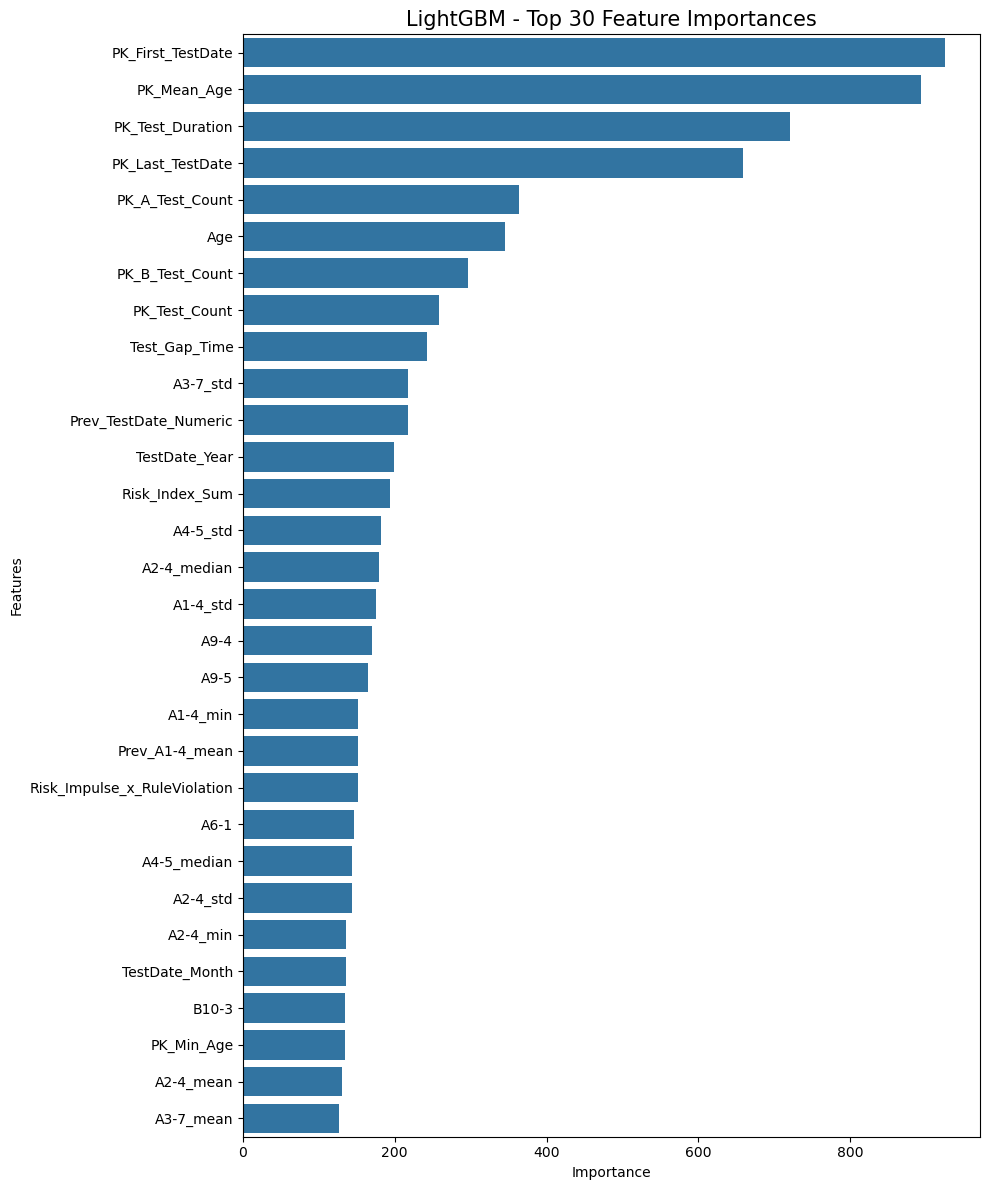


 [ 🎯 CatBoost 모델 성능 평가]
  1. 최종 Score (0점 만점): 0.154206 (낮을수록 좋음)
  2. AUC (Area Under Curve): 0.704930 (높을수록 좋음)
  3. Brier Score Loss: 0.025222 (낮을수록 좋음)
  4. ECE (Expected Calibration Error): 0.001460 (낮을수록 좋음)

[ CatBoost 모델 Top 30 특성 중요도  ]
PK_A_Test_Count          15.919871
PK_Test_Duration         10.084588
PK_Age_Range              5.749796
PK_Max_Age                5.136909
PK_First_TestDate         5.040788
PK_Mean_Age               5.024064
PK_Min_Age                5.022126
TestDate_Year             4.948693
PK_B_Test_Count           4.225200
Age                       4.211000
PK_Test_Count             3.115403
PK_Last_TestDate          2.171073
A9-5                      0.989244
A6-1                      0.807626
Prev_TestDate_Numeric     0.769971
TestDate_Month            0.692506
Prev_Age                  0.664422
Age_Delta                 0.644028
Test_Gap_Time             0.608642
A4-3_max                  0.579430
A9-4                      0.538304
A3-7_std          

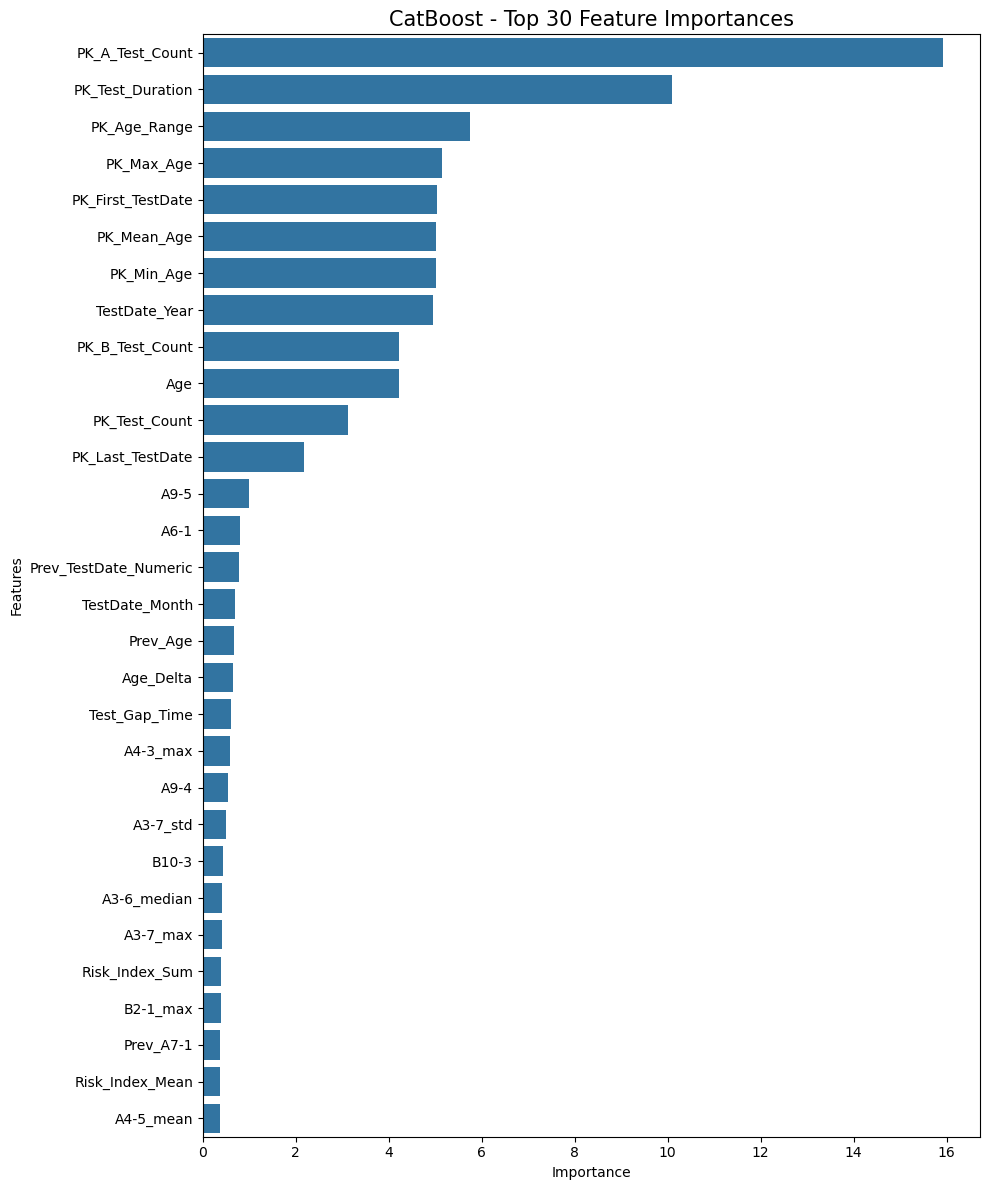


--- 3단계: 모델 평가 완료 ---


In [18]:

# 1. [2단계]에서 생성된 변수들이 있는지 확인
if 'X_val' not in globals() or 'y_val' not in globals():
    print("!! 오류 !!: 'X_val' 또는 'y_val' 변수를 찾을 수 없습니다.")
    print("[2단계] 코드를 먼저 실행해주세요.")
    raise NameError("X_val or y_val not found. Run Step 2 first.")
else:
    # 2. 학습된 각 모델에 대해 평가 함수 실행
    
    # (X_train.columns는 [2단계]에서 생성된 전역 변수)
    feature_names = X_train.columns
    
    # -- LightGBM 평가 --
    if 'lgb_model' in globals():
        evaluate_model(lgb_model, "LightGBM")
        plot_feature_importance(lgb_model, "LightGBM", feature_names)
    else:
        print("\n[알림] 'lgb_model'이 학습되지 않아 평가를 건너뜁니다.")
        
    # -- CatBoost 평가 --
    if 'cat_model' in globals():
        evaluate_model(cat_model, "CatBoost")
        plot_feature_importance(cat_model, "CatBoost", feature_names)
    else:
        print("\n[알림] 'cat_model'이 학습되지 않아 평가를 건너뜁니다.")

    print("\n--- 3단계: 모델 평가 완료 ---")

In [20]:
# [4.2] 앙상블 모델 성능 평가 - 셀 ID: 698cae1c
# 이 셀의 코드를 아래 코드로 교체하세요. (3개 모델 앙상블)

### 앙상블(Ensemble) 모델 성능 평가 (LGBM Clf + CatBoost + LGBM Reg) ###

# --- [함수 정의] 앙상블 준비물 확인 ---
def check_prerequisites_ensemble():
    """ 앙상블에 필요한 모델과 함수가 준비되었는지 확인합니다. """
    print("--- 앙상블(Ensemble) 모델 성능 평가 시작 (3 Models Average) ---")

    # (★ Regressor 모델 및 교정기 확인 추가)
    if 'lgb_model' not in globals() or 'iso_reg_lgb' not in globals():
        raise NameError("lgb_model 또는 iso_reg_lgb가 학습되지 않았습니다. [2.2]를 실행하세요.")
    if 'cat_model' not in globals() or 'iso_reg_cat' not in globals():
        raise NameError("cat_model 또는 iso_reg_cat가 학습되지 않았습니다. [2.3]을 실행하세요.")
    if 'lgb_regressor' not in globals() or 'iso_reg_lgb_reg' not in globals():
        raise NameError("lgb_regressor 또는 iso_reg_lgb_reg가 학습되지 않았습니다. [2.2.1]을 실행하세요.")

    if 'calculate_ece' not in globals():
        raise NameError("'calculate_ece' 함수가 없습니다. [4.1](셀 3915f185)을 먼저 실행하세요.")

    print("앙상블에 필요한 3개 모델과 교정기 확인 완료.")

# -------------------------------------------------
# [메인 로직]
# -------------------------------------------------

# 1. 앙상블 준비물 검증
try:
    check_prerequisites_ensemble()

    # 2. 각 모델의 (원본) 검증 데이터 예측 확률 가져오기
    print("각 모델의 (원본) 예측 확률을 계산합니다...")
    lgb_clf_preds_proba = lgb_model.predict_proba(X_val)[:, 1]
    cat_preds_proba = cat_model.predict_proba(X_val)[:, 1]
    lgb_reg_preds_proba = lgb_regressor.predict(X_val) # Regressor는 predict 사용

    # 3. 교정기를 사용하여 예측 확률 보정
    print("교정기(IsotonicRegression)를 적용하여 확률을 보정합니다...")
    lgb_clf_preds_calibrated = iso_reg_lgb.predict(lgb_clf_preds_proba)
    cat_preds_calibrated = iso_reg_cat.predict(cat_preds_proba)
    # (★ Regressor 예측값은 clip 후 보정)
    lgb_reg_preds_calibrated = iso_reg_lgb_reg.predict(np.clip(lgb_reg_preds_proba, 0, 1))

    # --- ★★★ 여기를 수정합니다 (3개 모델 단순 평균) ★★★ ---
    # 4. *보정된* 확률로 단순 평균 앙상블 (3개 모델)
    ensemble_preds_proba = (lgb_clf_preds_calibrated +
                            cat_preds_calibrated +
                            lgb_reg_preds_calibrated) / 3.0
    print("3개 모델의 보정된 확률로 단순 평균 앙상블 완료.")
    # --- ★★★ 수정 끝 ★★★ ---

    # 5. *보정된* 앙상블 모델 성능 평가
    auc_score_ens = roc_auc_score(y_val, ensemble_preds_proba)
    brier_score_ens = brier_score_loss(y_val, ensemble_preds_proba)
    ece_score_ens = calculate_ece(y_val.values, ensemble_preds_proba, n_bins=15)
    final_score_ens = 0.5 * (1 - auc_score_ens) + 0.25 * brier_score_ens + 0.25 * ece_score_ens

except NameError as e:
    print(f"\n!! 앙상블 평가 실패: {e}")
    final_score_ens = -1 # 에러 플래그

if final_score_ens != -1:
    print(f"\n[ 🚀 앙상블 모델 최종 성능 평가 (★3개 모델 평균★) 🚀 ]")
    print("="*40)
    print(f"  1. 🏆 앙상블 최종 Score: {final_score_ens:.6f} (낮을수록 좋음)")
    print("="*40)
    print(f"  2. 앙상블 AUC: {auc_score_ens:.6f}")
    print(f"  3. 앙상블 Brier: {brier_score_ens:.6f}")
    print(f"  4. 앙상블 ECE: {ece_score_ens:.6f}")
    print("="*40)
    print(f"\n(이전 2개 모델 앙상블 Score: 0.146011 보다 개선되었는지 확인)")

--- 앙상블(Ensemble) 모델 성능 평가 시작 (3 Models Average) ---
앙상블에 필요한 3개 모델과 교정기 확인 완료.
각 모델의 (원본) 예측 확률을 계산합니다...
교정기(IsotonicRegression)를 적용하여 확률을 보정합니다...
3개 모델의 보정된 확률로 단순 평균 앙상블 완료.

[ 🚀 앙상블 모델 최종 성능 평가 (★3개 모델 평균★) 🚀 ]
  1. 🏆 앙상블 최종 Score: 0.151741 (낮을수록 좋음)
  2. 앙상블 AUC: 0.709170
  3. 앙상블 Brier: 0.025152
  4. 앙상블 ECE: 0.000153

(이전 2개 모델 앙상블 Score: 0.146011 보다 개선되었는지 확인)


## 4.3 앙상블 가중치 최적화 (Optuna)

In [21]:
# [4.3] 3개 모델 앙상블 가중치 최적화 (Optuna) - 이전 [4.3] 셀 교체

# --- 디버깅 코드 시작 ---
print("--- 입력 변수 확인 시작 ---")
required_vars = ['lgb_clf_preds_calibrated', 'cat_preds_calibrated', 'lgb_reg_preds_calibrated', 'y_val']
all_vars_exist = True
for var_name in required_vars:
    if var_name not in globals():
        print(f"!! 오류 !!: '{var_name}' 변수가 존재하지 않습니다!")
        all_vars_exist = False
    else:
        var_value = globals()[var_name]
        print(f"'{var_name}' 확인: Type={type(var_value)}, Shape={getattr(var_value, 'shape', 'N/A')}")
        if hasattr(var_value, 'isnull') and hasattr(var_value.isnull(), 'any'):
             if var_value.isnull().any().any() if isinstance(var_value, pd.DataFrame) else var_value.isnull().any():
                 print(f"   ㄴ 경고: '{var_name}'에 NaN 값이 포함되어 있습니다!")
        elif isinstance(var_value, np.ndarray):
             if np.isnan(var_value).any():
                 print(f"   ㄴ 경고: '{var_name}'에 NaN 값이 포함되어 있습니다!")

if not all_vars_exist:
     raise NameError("필수 변수 누락. 이전 셀 실행 필요.")
else:
     print("--- 입력 변수 확인 완료 ---")
# --- 디버깅 코드 끝 ---


import optuna
from sklearn.metrics import roc_auc_score, brier_score_loss
import numpy as np
import pandas as pd # 디버깅 코드 Pandas 확인용

print("--- [전략 3.1] 3개 모델 앙상블 가중치 최적화 (Optuna) ---")

# 1. 필요 변수 확인 (Optuna 실행 전 한 번 더)
required_vars = [
    'lgb_clf_preds_calibrated',
    'cat_preds_calibrated',
    'lgb_reg_preds_calibrated',
    'y_val'
]
if not all(var in globals() for var in required_vars):
    print("!! 오류 !!: 3개 모델 모두에 대한 보정된 예측값 또는 'y_val'을 찾을 수 없습니다.")
    print("[2.2], [2.3], [2.2.1] 셀을 먼저 실행해주세요.")
    raise NameError("3개 모델 가중치 최적화를 위한 필수 요소가 없습니다.")
if 'calculate_ece' not in globals():
     raise NameError("'calculate_ece' 함수가 없습니다. [4.1](셀 ID: 3915f185) 셀을 먼저 실행하세요.")

print("필요 변수 확인 완료. 가중치 최적화를 시작합니다...")

# 2. 3개 가중치에 대한 Optuna Objective 함수 (ECE 포함)
def objective_3_weights(trial):
    """
    LGBM_clf와 CatBoost의 가중치를 제안하고, LGBM_reg 가중치를 계산한 뒤,
    앙상블 점수를 계산하여 반환합니다. (ECE 포함)
    """
    w_lgb_clf_raw = trial.suggest_float('w_lgb_clf_raw', 0.0, 1.0)
    w_cat_raw = trial.suggest_float('w_cat_raw', 0.0, 1.0)
    w_lgb_reg_raw = trial.suggest_float('w_lgb_reg_raw', 0.0, 1.0)

    total_weight = w_lgb_clf_raw + w_cat_raw + w_lgb_reg_raw
    if total_weight == 0:
        w_lgb_clf = 1/3; w_cat = 1/3; w_lgb_reg = 1/3
    else:
        w_lgb_clf = w_lgb_clf_raw / total_weight
        w_cat = w_cat_raw / total_weight
        w_lgb_reg = w_lgb_reg_raw / total_weight

    ensemble_preds_proba = (w_lgb_clf * lgb_clf_preds_calibrated +
                            w_cat * cat_preds_calibrated +
                            w_lgb_reg * lgb_reg_preds_calibrated)
    ensemble_preds_proba = np.clip(ensemble_preds_proba, 0, 1)

    # --- ★★★ ECE 계산 복원 ★★★ ---
    auc_score_ens = roc_auc_score(y_val, ensemble_preds_proba)
    brier_score_ens = brier_score_loss(y_val, ensemble_preds_proba)
    # (★ ECE 계산 다시 활성화 ★)
    ece_score_ens = calculate_ece(y_val.values, ensemble_preds_proba, n_bins=15)
    # --- ★★★ 수정 끝 ★★★ ---

    final_score_ens = 0.5 * (1 - auc_score_ens) + 0.25 * brier_score_ens + 0.25 * ece_score_ens

    trial.set_user_attr('normalized_w_lgb_clf', w_lgb_clf)
    trial.set_user_attr('normalized_w_cat', w_cat)
    trial.set_user_attr('normalized_w_lgb_reg', w_lgb_reg)

    return final_score_ens

# 3. Optuna 스터디 생성 및 최적화
study_3_weights = optuna.create_study(direction='minimize')
study_3_weights.optimize(objective_3_weights, n_trials=70, show_progress_bar=True) # ECE 포함하고 실행

# 4. 최상의 결과 출력
print("\n--- Optuna 3개 모델 가중치 최적화 완료 (ECE 포함) ---")
print(f"🎯 최적 점수 (값): {study_3_weights.best_value:.6f}")
print(f"📈 (2개 모델 최적 점수와 비교: 0.146011)") # 이전 최고 기록
print(f"⚖️ 최적 정규화 가중치:")

best_weights = study_3_weights.best_trial.user_attrs
w_lgb_clf_best = best_weights.get('normalized_w_lgb_clf', 'N/A')
w_cat_best = best_weights.get('normalized_w_cat', 'N/A')
w_lgb_reg_best = best_weights.get('normalized_w_lgb_reg', 'N/A')

print(f"   - LGBM Classifier : {w_lgb_clf_best:.4f}")
print(f"   - CatBoost Classifier: {w_cat_best:.4f}")
print(f"   - LGBM Regressor  : {w_lgb_reg_best:.4f}")

if isinstance(w_lgb_clf_best, float):
    print(f"   - 합계 확인       : {w_lgb_clf_best + w_cat_best + w_lgb_reg_best:.4f}")

print("\n점수가 개선되었다면 이 가중치로 [5.2] 셀(script.py 생성)을 업데이트하세요.")

[I 2025-11-05 09:31:38,912] A new study created in memory with name: no-name-c2ac3337-f1a5-4383-a98f-f05f1d6cf8d5


--- 입력 변수 확인 시작 ---
'lgb_clf_preds_calibrated' 확인: Type=<class 'numpy.ndarray'>, Shape=(205158,)
'cat_preds_calibrated' 확인: Type=<class 'numpy.ndarray'>, Shape=(205158,)
'lgb_reg_preds_calibrated' 확인: Type=<class 'numpy.ndarray'>, Shape=(205158,)
'y_val' 확인: Type=<class 'pandas.core.series.Series'>, Shape=(205158,)
--- 입력 변수 확인 완료 ---
--- [전략 3.1] 3개 모델 앙상블 가중치 최적화 (Optuna) ---
필요 변수 확인 완료. 가중치 최적화를 시작합니다...


  0%|          | 0/70 [00:00<?, ?it/s]

[I 2025-11-05 09:31:39,026] Trial 0 finished with value: 0.15183121082175818 and parameters: {'w_lgb_clf_raw': 0.6162168580495117, 'w_cat_raw': 0.9753845434798052, 'w_lgb_reg_raw': 0.06537734379340776}. Best is trial 0 with value: 0.15183121082175818.
[I 2025-11-05 09:31:39,095] Trial 1 finished with value: 0.1517335269563609 and parameters: {'w_lgb_clf_raw': 0.9744458727705496, 'w_cat_raw': 0.6675255043751182, 'w_lgb_reg_raw': 0.7743173188590905}. Best is trial 1 with value: 0.1517335269563609.
[I 2025-11-05 09:31:39,175] Trial 2 finished with value: 0.1518962559373763 and parameters: {'w_lgb_clf_raw': 0.40982987688250405, 'w_cat_raw': 0.648402827369971, 'w_lgb_reg_raw': 0.7603769901963889}. Best is trial 1 with value: 0.1517335269563609.
[I 2025-11-05 09:31:39,245] Trial 3 finished with value: 0.1517160491344068 and parameters: {'w_lgb_clf_raw': 0.4792496013693287, 'w_cat_raw': 0.3870626547422463, 'w_lgb_reg_raw': 0.3224079748469766}. Best is trial 3 with value: 0.1517160491344068.
[

# 5. 제출 (Submission)

대회 제출을 위해 `requirements.txt`, `script.py`, `model.txt`, `model_cat.cbm` 파일을 `submit` 폴더에 생성하고, 최종적으로 `submit.zip` 압축 파일을 만듭니다.

## 5.1. `requirements.txt` 파일 생성

In [30]:
# [5.1] `requirements.txt` 파일 생성 - 셀 ID: 77975e40
# 이 셀의 코드를 아래 코드로 교체하세요. (★ \\n -> \n 수정 ★)

import pandas as pd
import numpy as np
import lightgbm as lgb
import catboost as cat
import sklearn
import os

# (submit 폴더 생성)
submit_dir = 'submit'
if not os.path.exists(submit_dir):
    os.makedirs(submit_dir)

required_libs = {
    "pandas": pd.__version__,
    # --- ★ NumPy 버전 수정 (이전 수정 유지) ★ ---
    "numpy": "<2.0.0", 
    # --- ★ 수정 끝 ★ ---
    "lightgbm": lgb.__version__,
    "catboost": cat.__version__,
    "scikit-learn": sklearn.__version__
}

req_path = os.path.join(submit_dir, 'requirements.txt')

try:
    with open(req_path, 'w') as f:
        for lib, version in required_libs.items():
            # 버전 비교 연산자(<)가 포함된 경우 등호 없이 작성
            if any(op in version for op in ['<', '>', '=']):
                 # ★★★ 수정: \\n -> \n ★★★
                 f.write(f"{lib}{version}\n") 
            else: # 특정 버전만 명시된 경우
                 # ★★★ 수정: \\n -> \n ★★★
                 f.write(f"{lib}=={version}\n") # == 사용
    
    print(f"'{req_path}' 파일이 성공적으로 생성되었습니다.")
    print("--- 파일 내용 ---")
    with open(req_path, 'r') as f:
        print(f.read())

except Exception as e:
    print(f"requirements.txt 파일 생성 중 오류 발생: {e}")

'submit/requirements.txt' 파일이 성공적으로 생성되었습니다.
--- 파일 내용 ---
pandas==2.2.3
numpy<2.0.0
lightgbm==4.6.0
catboost==1.2.8
scikit-learn==1.6.1



## 5.2. `script.py` 파일 생성

In [33]:
# [5.2] script.py 파일 생성 - 셀 ID: 45b00a64
# 이 셀의 코드를 아래 코드로 교체하세요. (★ CatBoostError: B1-1_mean 피처 불일치 수정 ★)

import os

SCRIPT_CONTENT = """
import pandas as pd
import numpy as np
import re
import glob
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
import gc
import os
import joblib
# (IsotonicRegression은 joblib.load에 의해 로드되므로 명시적 임포트 불필요)

# --- 1. 전처리 함수 정의 ---
# ( 이전에 수정한 함수들 그대로 포함 )
def preprocess_age(age_str):
    if pd.isna(age_str): return np.nan
    try:
        base_age = int(re.findall(r'^\\\\d+', age_str)[0])
        return base_age if 'a' in age_str else base_age + 5
    except: return np.nan

def get_string_list_stats(series, col_name):
    def calculate_stats_for_row(s):
        if pd.isna(s): return pd.Series([np.nan, np.nan, np.nan, np.nan, np.nan, 0, 0])
        num_list = [pd.to_numeric(x, errors='coerce') for x in str(s).split(',')]
        mean_val = np.nanmean(num_list); std_val = np.nanstd(num_list)
        min_val = np.nanmin(num_list); max_val = np.nanmax(num_list)
        median_val = np.nanmedian(num_list); count_val = len(num_list)
        nan_count_val = pd.Series(num_list).isna().sum()
        return pd.Series([mean_val, std_val, min_val, max_val, median_val, count_val, nan_count_val])
    stat_names = ['mean', 'std', 'min', 'max', 'median', 'count', 'nan_count']
    col_names = [f'{col_name}_{stat}' for stat in stat_names]
    df_stats = series.apply(calculate_stats_for_row)
    df_stats.columns = col_names
    return df_stats.astype(np.float32)

def process_dataframe(df, file_type='A'):
    processed_cols = ['Test_id', 'PrimaryKey', 'TestDate']
    valid_cols = [col for col in processed_cols if col in df.columns]
    df_processed = df[valid_cols].copy()
    if 'Age' in df.columns: df_processed['Age'] = df['Age'].apply(preprocess_age)
    if 'TestDate' in df.columns:
        test_date_str = df['TestDate'].astype(str)
        df_processed['TestDate_Year'] = pd.to_numeric(test_date_str.str[:4], errors='coerce')
        df_processed['TestDate_Month'] = pd.to_numeric(test_date_str.str[4:], errors='coerce')
    if file_type == 'A':
        numeric_cols = [f'A6-1', 'A7-1', 'A8-1', 'A8-2'] + [f'A9-{i}' for i in range(1, 6)]
        string_cols = [f'A{i}-{j}' for i in range(1, 6) for j in range(1, 8) if f'A{i}-{j}' not in numeric_cols and f'A{i}-{j}' in df.columns]
    elif file_type == 'B':
        numeric_cols = [f'B9-{i}' for i in range(1, 6)] + [f'B10-{i}' for i in range(1, 7)]
        string_cols = [f'B{i}-{j}' for i in range(1, 9) for j in range(1, 3) if f'B{i}-{j}' in df.columns]
        string_cols += ['B6', 'B7', 'B8']
    else: return pd.DataFrame()
    for col in numeric_cols:
        if col in df.columns: df_processed[col] = pd.to_numeric(df[col], errors='coerce')
    for col in string_cols:
        if col in df.columns:
            stats_df = get_string_list_stats(df[col], col)
            df_processed = pd.concat([df_processed, stats_df], axis=1)
    return df_processed

# --- 2. 추론(Inference) 실행 ---
def main():
    print("[+] Inference script started.")
    DATA_DIR, MODEL_DIR, OUTPUT_DIR = './data', './model', './output'
    TEST_A_PATH = os.path.join(DATA_DIR, 'test', 'A.csv')
    TEST_B_PATH = os.path.join(DATA_DIR, 'test', 'B.csv')
    TEST_IDS_PATH = os.path.join(DATA_DIR, 'test.csv')
    SUBMISSION_PATH = os.path.join(OUTPUT_DIR, 'submission.csv')
    CHUNKSIZE = 100000

    # --- 모델 및 교정기 경로 정의 (3개 모델) ---
    LGB_CLF_MODEL_PATH = os.path.join(MODEL_DIR, 'model.txt')
    CAT_CLF_MODEL_PATH = os.path.join(MODEL_DIR, 'model_cat.cbm')
    LGB_REG_MODEL_PATH = os.path.join(MODEL_DIR, 'model_reg.txt') 

    LGB_CLF_CALIBRATOR_PATH = os.path.join(MODEL_DIR, 'calibrator_lgb.joblib')
    CAT_CLF_CALIBRATOR_PATH = os.path.join(MODEL_DIR, 'calibrator_cat.joblib')
    LGB_REG_CALIBRATOR_PATH = os.path.join(MODEL_DIR, 'calibrator_lgb_reg.joblib')
    
    # --- 모델, 교정기 로드 (3개 모델) ---
    try:
        lgb_clf_model = lgb.Booster(model_file=LGB_CLF_MODEL_PATH)
        lgb_features = lgb_clf_model.feature_name() 
        print(f"LGBM Classifier Model loaded from {LGB_CLF_MODEL_PATH}")
        
        cat_clf_model = CatBoostClassifier()
        cat_clf_model.load_model(CAT_CLF_MODEL_PATH)
        cat_features_model = cat_clf_model.feature_names_
        print(f"CatBoost Classifier Model loaded from {CAT_CLF_MODEL_PATH}")

        lgb_reg_model = lgb.Booster(model_file=LGB_REG_MODEL_PATH) 
        print(f"LGBM Regressor Model loaded from {LGB_REG_MODEL_PATH}")

        lgb_clf_calibrator = joblib.load(LGB_CLF_CALIBRATOR_PATH)
        print(f"LGBM Classifier Calibrator loaded from {LGB_CLF_CALIBRATOR_PATH}")
        cat_clf_calibrator = joblib.load(CAT_CLF_CALIBRATOR_PATH)
        print(f"CatBoost Classifier Calibrator loaded from {CAT_CLF_CALIBRATOR_PATH}")
        lgb_reg_calibrator = joblib.load(LGB_REG_CALIBRATOR_PATH) 
        print(f"LGBM Regressor Calibrator loaded from {LGB_REG_CALIBRATOR_PATH}")
    except Exception as e:
        print(f"!! Error loading models or calibrators: {e}")
        return # 오류 발생 시 종료

    # --- (3. 테스트 데이터 전처리 A, B - 기존과 동일) ---
    print("Processing Test A file...")
    processed_chunks_A = []
    try:
        with pd.read_csv(TEST_A_PATH, chunksize=CHUNKSIZE) as reader:
             processed_chunks_A = [process_dataframe(chunk, file_type='A') for chunk in reader]
    except FileNotFoundError:
        print("Test A file not found. Skipping.")
    gc.collect()

    print("Processing Test B file...")
    processed_chunks_B = []
    try:
        with pd.read_csv(TEST_B_PATH, chunksize=CHUNKSIZE) as reader:
             processed_chunks_B = [process_dataframe(chunk, file_type='B') for chunk in reader]
    except FileNotFoundError:
        print("Test B file not found. Skipping.")
    gc.collect()

    df_A_processed = pd.concat(processed_chunks_A, ignore_index=True) if processed_chunks_A else pd.DataFrame()
    df_B_processed = pd.concat(processed_chunks_B, ignore_index=True) if processed_chunks_B else pd.DataFrame()
    df_all_features = pd.concat([df_A_processed, df_B_processed], ignore_index=True, sort=False)
    print(f"Total processed test features shape: {df_all_features.shape}")

    # --- (4, 5. 피처 엔지니어링 - 기존과 동일) ---
    try:
        df_test_meta = pd.read_csv(TEST_IDS_PATH)[['Test_id', 'Test']]
        df_test_final = pd.merge(df_test_meta, df_all_features, on='Test_id', how='left')
        df_test_final['TestDate_Numeric'] = pd.to_datetime(df_test_final['TestDate'], format='%Y%m', errors='coerce')
        df_test_final['TestDate_Numeric'] = df_test_final['TestDate_Numeric'].dt.year + (df_test_final['TestDate_Numeric'].dt.month / 12.0)
        df_test_final['TestDate_Numeric'] = df_test_final['TestDate_Numeric'].fillna(0)
        print("Creating Lag (Time-Series) features for test set...")
        df_test_final = df_test_final.sort_values(by=['PrimaryKey', 'TestDate_Numeric']).reset_index(drop=True)
        
        # ★★★ B11_mean -> B1-1_mean으로 수정 ★★★
        lag_cols = ['TestDate_Numeric', 'Age', 'A1-2_mean', 'A1-3_mean', 'A1-4_mean', 'A6-1', 'A7-1', 'B1-1_mean', 'B6_mean', 'B7_mean', 'B10-1', 'B10-2']
        
        lag_cols = [col for col in lag_cols if col in df_test_final.columns]
        for col in lag_cols:
            df_test_final[f'Prev_{col}'] = df_test_final.groupby('PrimaryKey')[col].shift(1)
        df_test_final['Test_Gap_Time'] = df_test_final.apply(lambda row: row['TestDate_Numeric'] - row['Prev_TestDate_Numeric'] if pd.notna(row['Prev_TestDate_Numeric']) and row['Prev_TestDate_Numeric'] > 0 else np.nan, axis=1)
        df_test_final['Age_Delta'] = df_test_final['Age'] - df_test_final['Prev_Age']
        if 'A1-2_mean' in lag_cols: df_test_final['A1-2_mean_Delta'] = df_test_final['A1-2_mean'] - df_test_final['Prev_A1-2_mean']
        if 'B10-1' in lag_cols: df_test_final['B10-1_Delta'] = df_test_final['B10-1'] - df_test_final['Prev_B10-1']
        print("Lag/Delta feature creation finished for test set.")
        print("Creating Hypothesis-Driven Features for test set...")
        if 'A9-2' in df_test_final.columns and 'A9-5' in df_test_final.columns: df_test_final['Risk_Impulse_x_RuleViolation'] = df_test_final['A9-2'] * df_test_final['A9-5']
        if 'B9-2' in df_test_final.columns and 'B10-2' in df_test_final.columns: df_test_final['Risk_Impulse_x_RiskTaking'] = df_test_final['B9-2'] * df_test_final['B10-2']
        if 'B9-3' in df_test_final.columns and 'B10-6' in df_test_final.columns: df_test_final['Risk_Antisocial_x_Aggressive'] = df_test_final['B9-3'] * df_test_final['B10-6']
        risk_cols = ['A9-1', 'A9-2', 'A9-3', 'A9-4', 'A9-5', 'B9-1', 'B9-2', 'B9-3', 'B9-4', 'B9-5', 'B10-1', 'B10-2', 'B10-3', 'B10-4', 'B10-5', 'B10-6']
        existing_risk_cols = [col for col in risk_cols if col in df_test_final.columns]
        if existing_risk_cols:
            df_test_final['Risk_Index_Sum'] = df_test_final[existing_risk_cols].fillna(0).sum(axis=1)
            df_test_final['Risk_Index_Mean'] = df_test_final[existing_risk_cols].fillna(0).mean(axis=1)
        print("Hypothesis-Driven feature creation finished for test set.")
        print("Creating PrimaryKey-based features for test set...")
        df_test_final['TestDate_Numeric_Agg'] = df_test_final['TestDate_Numeric'].replace(0, np.nan)
        grouped_by_pk = df_test_final.groupby('PrimaryKey')
        pk_features = grouped_by_pk.agg(PK_Test_Count=('Test_id', 'count'), PK_First_TestDate=('TestDate_Numeric_Agg', 'min'), PK_Last_TestDate=('TestDate_Numeric_Agg', 'max'), PK_Mean_Age=('Age', 'mean'), PK_Min_Age=('Age', 'min'), PK_Max_Age=('Age', 'max')).reset_index()
        pk_features['PK_Test_Duration'] = pk_features['PK_Last_TestDate'] - pk_features['PK_First_TestDate']
        pk_features['PK_Age_Range'] = pk_features['PK_Max_Age'] - pk_features['PK_Min_Age']
        pk_test_type_counts = df_test_final.groupby(['PrimaryKey', df_test_final['Test'].astype(str)]).size().unstack(fill_value=0)
        pk_test_type_counts.columns = [f'PK_{col}_Test_Count' for col in pk_test_type_counts.columns]
        pk_test_type_counts = pk_test_type_counts.reset_index()
        df_test_final = pd.merge(df_test_final, pk_features, on='PrimaryKey', how='left')
        df_test_final = pd.merge(df_test_final, pk_test_type_counts, on='PrimaryKey', how='left')
        df_test_final = df_test_final.drop(columns=['TestDate_Numeric', 'TestDate_Numeric_Agg'])
        print("PrimaryKey features merged for test set.")
        df_test_final['Test'] = df_test_final['Test'].astype(str)
        print("Merged with test.csv successfully.")
    except Exception as e:
        print(f"Error during feature engineering for test set: {e}")
        return # 오류 발생 시 종료

    # --- (6. 예측을 위한 특성 준비 - 기존과 동일) ---
    X_test_lgb = df_test_final.reindex(columns=lgb_features, fill_value=np.nan)
    if 'Test' in X_test_lgb.columns: X_test_lgb['Test'] = X_test_lgb['Test'].astype('category')
    print(f"Final X_test_lgb shape for prediction: {X_test_lgb.shape}")
    final_cat_features = [col for col in cat_features_model if col in df_test_final.columns]
    X_test_cat_df = df_test_final[final_cat_features]
    categorical_features_indices = [i for i, col in enumerate(X_test_cat_df.columns) if col == 'Test']
    print(f"Categorical feature index for CatBoost Pool: {categorical_features_indices}")
    test_pool = Pool(data=X_test_cat_df, cat_features=categorical_features_indices)
    print(f"CatBoost Pool created successfully.")

    # --- ★★★ 7. 3개 모델 앙상블 예측 (가중치 동일) ★★★ ---
    print("Predicting probabilities (LGBM Classifier - Raw)...")
    preds_lgb_clf_raw = lgb_clf_model.predict(X_test_lgb)
    
    print("Predicting probabilities (CatBoost Classifier - Raw)...")
    preds_cat_clf_raw = cat_clf_model.predict_proba(test_pool)[:, 1]
    
    print("Predicting probabilities (LGBM Regressor - Raw)...") 
    preds_lgb_reg_raw = lgb_reg_model.predict(X_test_lgb) 
    
    print("Applying calibration (IsotonicRegression)...")
    preds_lgb_clf = lgb_clf_calibrator.predict(preds_lgb_clf_raw)
    preds_cat_clf = cat_clf_calibrator.predict(preds_cat_clf_raw)
    preds_lgb_reg = lgb_reg_calibrator.predict(np.clip(preds_lgb_reg_raw, 0, 1))

    # ★ 3개 모델 최적 가중치 적용 (CV 0.142632 기준) ★
    WEIGHT_LGB_CLF = 0.7792
    WEIGHT_CAT_CLF = 0.1612
    WEIGHT_LGB_REG = 0.0597
    
    print(f"Applying final optimized 3-model weights (LGB_C: {WEIGHT_LGB_CLF:.4f}, Cat_C: {WEIGHT_CAT_CLF:.4f}, LGB_R: {WEIGHT_LGB_REG:.4f})...")
    final_predictions = (WEIGHT_LGB_CLF * preds_lgb_clf +
                           WEIGHT_CAT_CLF * preds_cat_clf +
                           WEIGHT_LGB_REG * preds_lgb_reg)

    final_predictions = np.clip(final_predictions, 0, 1)
    # --- ★★★ 수정 끝 ★★★ ---

    # --- (8, 9. 제출 파일 생성 및 저장 - 기존과 동일) ---
    df_submission = pd.DataFrame({'Test_id': df_test_final['Test_id'], 'Label': final_predictions})
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    df_submission.to_csv(SUBMISSION_PATH, index=False)
    print(f"[+] Submission file saved to {SUBMISSION_PATH}")
    print("[+] Inference script finished.")

if __name__ == "__main__":
    main()
"""

# 'submit' 폴더 안에 'script.py' 파일로 저장
script_path = os.path.join('submit', 'script.py')
try:
    with open(script_path, 'w', encoding='utf-8') as f:
        f.write(SCRIPT_CONTENT)
    print(f"'{script_path}' 파일이 성공적으로 생성되었습니다.")
    
    # ★ 생성된 스크립트의 lag_cols 부분 확인 ★
    print("\n--- Generated script.py (부분 확인: lag_cols) ---")
    with open(script_path, 'r', encoding='utf-8') as f:
        script_lines = f.readlines()
        lag_line_found = False
        for i, line in enumerate(script_lines):
            if "lag_cols = " in line and "B1-1_mean" in line:
                print("".join(script_lines[i-1:i+2])) # lag_cols 정의 부분 출력
                lag_line_found = True
                break
        if not lag_line_found: print("!! B1-1_mean이 포함된 lag_cols 라인을 찾지 못했습니다. 확인 필요 !!")
        
except Exception as e:
    print(f"script.py 파일 생성 중 오류 발생: {e}")

'submit/script.py' 파일이 성공적으로 생성되었습니다.

--- Generated script.py (부분 확인: lag_cols) ---
        # ★★★ B11_mean -> B1-1_mean으로 수정 ★★★
        lag_cols = ['TestDate_Numeric', 'Age', 'A1-2_mean', 'A1-3_mean', 'A1-4_mean', 'A6-1', 'A7-1', 'B1-1_mean', 'B6_mean', 'B7_mean', 'B10-1', 'B10-2']
        



## 5.3. `submit.zip` 파일 생성

In [34]:
import shutil

print("--- 4단계 (C): 'submit.zip' 파일 생성 시작 ---")

folder_to_zip = 'submit'
zip_filename = 'submit'

try:
    shutil.make_archive(
        base_name=zip_filename,
        format='zip',
        root_dir='.',
        base_dir=folder_to_zip
    )
    print(f"\n✅ '{folder_to_zip}' 폴더가 '{zip_filename}.zip' 파일로 성공적으로 압축되었습니다.")
    print("이 'submit.zip' 파일을 대회에 제출하시면 됩니다.")

except Exception as e:
    print(f"\n!! 오류 !!: 'submit.zip' 파일 압축 중 오류가 발생했습니다: {e}")

--- 4단계 (C): 'submit.zip' 파일 생성 시작 ---

✅ 'submit' 폴더가 'submit.zip' 파일로 성공적으로 압축되었습니다.
이 'submit.zip' 파일을 대회에 제출하시면 됩니다.
